# GDL Mini-project.

In this notebook we study the effect of orthogonal weights and dynamical isometry in GCNs.
First install dependencies.

### Install dependencies [RUN]

In [14]:
!pip install torch-geometric
!pip install bayesian-optimization

In [15]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization

from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import WebKB
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv

import pickle

plt.style.use('https://github.com/filangel/mplstyles/raw/main/matlab.mplstyle')
plt.rcParams['figure.dpi'] = 150

In [16]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Section: Models.

In this section we implement the Baseline GCN model, the Gaussian-initialized model, and the ortohogonal-initialized model with orthogonal penalty. Run all the cells in this section

## MODEL: GCN with ERF activation [RUN]

In [17]:
# Define the erf activation: erf(sqrt(pi)/2 * x)
def erf_activation(x):
    constant = math.sqrt(math.pi) / 2  # sqrt(pi)/2
    return torch.erf(constant * x)

In [18]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, activation):
        super(GCN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        self.layers.append(nn.Linear(hidden_channels, out_channels))
        self.activation = activation
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, x, edge_index,return_latent=False):
        x = self.layers[0](x)
        x = self.activation(x)

        for conv in self.layers[1:-1]:
            x = conv(x, edge_index)
            x = self.activation(x)

        latent = x.clone()
        logits = self.layers[-1](x)
        if return_latent:
            return logits, latent
        else:
            return logits


## GCN with Gaussian Init [RUN]

In [19]:
# Define a simple deep GCN model using the erf activation function.
class InitGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, sigma, activation):
        """
        Args:
            in_channels: Dimension of input features.
            hidden_channels: Dimension of hidden layers.
            out_channels: Number of output classes.
            num_layers: Total number of layers (including first and last).
            sigma: Standard deviation for weight initialization.
            dropout: Dropout probability.
        """
        super(InitGCN, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Linear(in_channels, hidden_channels))
        # Hidden layers.
        for _ in range(num_layers):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        self.convs.append(nn.Linear(hidden_channels, out_channels))
        self.sigma = sigma
        self.activation = activation
        self.reset_parameters()

    def reset_parameters(self):
        # Reset parameters and reinitialize weights from N(0, sigma)
        self.convs[0].reset_parameters()
        self.convs[-1].reset_parameters()

        for conv in self.convs[1:-1]:
            conv.reset_parameters()
            if hasattr(conv, 'lin'):
                nn.init.normal_(conv.lin.weight, mean=0, std=self.sigma/math.sqrt(hidden_channels))
                if conv.lin.bias is not None:
                    nn.init.zeros_(conv.lin.bias)

        #for bn in self.bns:
         #   bn.reset_parameters()

    def forward(self, x, edge_index, return_latent=False):
        x = self.convs[0](x)
        x = self.activation(x)

        for i,conv in enumerate(self.convs[1:-1]):
            residual = x  # store the input for the skip connection
            x = conv(x, edge_index)
            x = self.activation(x)
            #x = residual + x  # add residual connection

        latent = x.clone()
        logits = self.convs[-1](x)
        if return_latent:
            return logits, latent
        else:
            return logits



## MODEL: ORTHREGGCN [RUN]

In [20]:
class OrthRegGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, activation=erf_activation, gamma=1.0,mu=1e-4):
        """
        A deep GCN with orthogonal weight initialization and an additional orthogonal regularization penalty.

        Args:
            in_channels: Dimension of input features.
            hidden_channels: Dimension of hidden layers.
            out_channels: Number of output classes.
            num_layers: Total number of layers (including first and last).
            sigma: Standard deviation for weight initialization (unused here since we use orthogonal init).
            activation: Activation function.
            dropout: Dropout probability.
        """
        super(OrthRegGCN, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(nn.Linear(hidden_channels, out_channels))
        self.activation = activation
        self.gamma = gamma
        self.mu=mu
        self.reset_parameters()

    def reset_parameters(self):
        # Reset parameters and reinitialize weights using orthogonal initialization.
        self.convs[0].reset_parameters()
        self.convs[-1].reset_parameters()
        for conv in self.convs[1:-1]:
            conv.reset_parameters()
            if hasattr(conv, 'lin'):
                nn.init.orthogonal_(conv.lin.weight)
                conv.lin.weight.data.mul(self.gamma)
                if conv.lin.bias is not None:
                    nn.init.zeros_(conv.lin.bias)
        #for bn in self.bns:
         #   bn.reset_parameters()

    def orth_reg_loss(self):
        """Compute the orthogonal regularization penalty: sum ||WᵀW - I||_F² for each linear layer."""
        reg_loss = 0
        for conv in self.convs[1:-1]:
            if hasattr(conv, 'lin'):
                W = conv.lin.weight  # Shape: [out_features, in_features]
                # Create identity of appropriate size (using in_features dimension)
                I = torch.eye(W.size(1), device=W.device, dtype=W.dtype)
                reg_loss += ((W.t() @ W - (self.gamma**2)*I) ** 2).sum()
        return self.mu * reg_loss

    def forward(self, x, edge_index, return_latent=False):
        x = self.convs[0](x)
        x = self.activation(x)

        # Hidden layers with residual connections.
        for i,conv in enumerate(self.convs[1:-1]):
            residual = x  # store the input for the skip connection
            x = conv(x, edge_index)
            x = self.activation(x)
            #x = residual + x  # add residual connection

        latent = x.clone()
        logits = self.convs[-1](x)
        if return_latent:
            return logits, latent
        else:
            return logits

## Train test functions [RUN]

In [21]:
def train(model, model_type, data, optimizer, device):
    model.train()
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    #data.train_mask = fix_mask(data.train_mask)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask].to(device))
    # For orth_reg model, add the regularization term.
    if model_type == 'orth_reg':
        loss = loss + model.orth_reg_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function: returns [train_acc, val_acc, test_acc].
def test(model, data, device):
    model.eval()
    data_x = data.x.to(device)
    data_edge_index = data.edge_index.to(device)
    data_y = data.y.to(device)
    logits = model(data_x, data_edge_index)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        #mask = fix_mask(mask)
        mask = mask.to(device)
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data_y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


In [22]:
def dirichlet_energy_from_data(x, data):
    # x: latent representation of shape [N, d]
    # data.edge_index: tensor of shape [2, num_edges]
    row, col = data.edge_index
    diff = x[row] - x[col]
    # Sum over all edges and divide by 2 (if each edge is counted twice).
    energy = (diff ** 2).sum() / 2.0
    return energy.item()

### Original exp


# EXPERIMENTS

### TRAINING PARAMS AND CONFIGS [RUN]

In [27]:
layer_configs = [4,10,20,30,40,50,60]
model_types = ['baseline','init_gcn','orth_reg','orth_no_penalty']
training_params = {
    'hidden_channels': 128,
    'max_epochs': 151,
    'patience': 200,
    'lr': 0.001
}
activations = [erf_activation,nn.Tanh(),nn.ReLU(),nn.Identity()]

### Experiment: Unified functions for training models and evaluating on datasets [RUN]

In [28]:
# A unified experiment function that accepts a dataset name.
def run_experiment_dataset(model_type='baseline', dataset_name='Cora', sigma=0.155,
                             num_layers=4, hidden_channels=256, max_epochs=100, gamma=1.0,
                             patience=100, lr=0.001, weight_decay=0, orth_reg_weight=1e-4,
                             activation=nn.ReLU(),device='cpu'):
    # Load the dataset.
    if dataset_name == 'Texas':
      dataset = WebKB(root='data/WebKB', name='Texas',transform=T.GCNNorm())
    else:
      dataset = Planetoid(root=f'data/{dataset_name}', name=dataset_name, transform=T.GCNNorm())
    data = dataset[0]

    # Select the model variant.
    if model_type == 'baseline':
        model = GCN(in_channels=dataset.num_node_features,
                        hidden_channels=hidden_channels,
                        out_channels=dataset.num_classes,
                        num_layers=num_layers, activation=activation).to(device)
    elif model_type == 'init_gcn':
        model = InitGCN(in_channels=dataset.num_node_features,
                        hidden_channels=hidden_channels,
                        out_channels=dataset.num_classes,
                        num_layers=num_layers, activation=activation,
                        sigma=sigma).to(device)
    elif model_type == 'orth_reg' or model_type == 'orth_no_penalty':
        model = OrthRegGCN(in_channels=dataset.num_node_features,
                               hidden_channels=hidden_channels,
                               out_channels=dataset.num_classes, gamma=gamma,mu=orth_reg_weight,
                               num_layers=num_layers, activation=activation).to(device)
    else:
        raise ValueError("Unknown model_type. Choose 'baseline', 'init_gcn' or 'orth_reg'.")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5)

    best_val_acc = 0
    best_epoch = 0
    test_acc_at_best_val = 0
    patience_counter = 0

    for epoch in range(max_epochs):
        loss = train(model, model_type, data, optimizer, device)
        train_acc, val_acc, test_acc = test(model, data, device)
        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            test_acc_at_best_val = test_acc
            patience_counter = 0
        else:
            patience_counter += 1
        if epoch % 10 == 0:
          print(f"[{dataset_name} | {model_type} | Layers: {num_layers}] Epoch: {epoch:03d}, Loss: {loss:.4f}, "
              f"Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (best epoch {best_epoch} with val acc {best_val_acc:.4f})")
            break

    model.eval()
    with torch.no_grad():
        _, latent = model(data.x.to(device), data.edge_index.to(device), return_latent=True)
    energy = dirichlet_energy_from_data(latent, data)
    return test_acc_at_best_val,energy

In [29]:
def run_for_results(model_type, model_name, dataset_name = "Cora", best_sigmas={}, best_orth_params={}, num_runs=5):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Dictionary to store raw results.
    # Structure: results[activation_name][num_layers] = list of test accuracies from num_runs.
    results = {}

    # Loop over each activation function.
    for act in activations:
        act_name = act.__class__.__name__
        results[act_name] = {}
        for nl in layer_configs:
            results[act_name][nl] = []
            for run in range(num_runs):
                print(f"Running experiment on {dataset_name} | Activation: {act_name} | Layers: {nl} | Run {run+1}/{num_runs}")
                sigma = best_sigmas[nl][act_name] if model_type == 'init_gcn' else None
                gamma = best_orth_params[nl][act_name]['gamma'] if model_type in ['orth_reg', 'orth_no_penalty'] else 1
                orth_reg_weight = best_orth_params[nl][act_name]['orth_reg_weight'] if model_type == 'orth_reg' else None

                test_acc,_ = run_experiment_dataset(
                    model_type=model_type,
                    dataset_name=dataset_name,
                    num_layers=nl,
                    hidden_channels=training_params["hidden_channels"],
                    max_epochs=training_params["max_epochs"],
                    patience=training_params["patience"],
                    lr=training_params["lr"],
                    weight_decay=0,
                    activation=act,
                    sigma=sigma,
                    gamma=gamma,
                    orth_reg_weight=orth_reg_weight,
                    device=device
                )
                results[act_name][nl].append(test_acc)

    # Compute summary statistics (mean and std) for each combination.
    summary_results = {}  # summary_results[activation_name][num_layers] = (mean, std)
    for nl in layer_configs:
      summary_results[nl] = {}
      for act in activations:
          act_name = act.__class__.__name__
          accs = np.array(results[act_name][nl])
          mean_acc = np.mean(accs)
          std_acc = np.std(accs, ddof=1)
          summary_results[nl][act_name] = (mean_acc, std_acc)

    # Save the summary results to a file.
    with open(f"./{model_name}_results_Cora.pkl", "wb") as f:
        pickle.dump(summary_results, f)
    print(f"Summary results saved to {model_name}_results_Cora.pkl.")
    return summary_results


In [30]:
def plot_experiment(model_type, summary_results, layer_configs, activations):
    plt.figure(figsize=(10, 6))
    for act in activations:
        act_name = act.__class__.__name__
        x = []
        y = []
        yerr = []
        # For each activation, get the result for each layer from summary_results
        for nl in sorted(layer_configs):
            mean_acc, std_acc = summary_results[nl][act_name]
            x.append(nl)
            y.append(mean_acc)
            yerr.append(std_acc)
        # Plot the line for this activation function
        plt.plot(x, y, marker='o', label=act_name)
        # Fill the area between mean-std and mean+std
        plt.fill_between(x,
                        [m - s for m, s in zip(y, yerr)],
                        [m + s for m, s in zip(y, yerr)],
                        alpha=0.2)

    plt.xlabel("Number of Layers")
    plt.ylabel("Test Accuracy")
    plt.title(f"{model_type} Test Accuracy vs. Number of Layers (Cora)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optionally, print a summary of the results.
    print("\nSummary of Results for Cora:")
    for nl in sorted(summary_results.keys()):
        for act_name in sorted(summary_results[nl].keys()):
            mean_acc, std_acc = summary_results[nl][act_name]
            print(f"  Activation: {act_name}, {nl} layers: {mean_acc:.4f} ± {std_acc:.4f}")

### BASELINE GCN EXPERIMENT

Run the baseline model on Cora 5 times and report mean and standard deviation. The following cell may take longe to execute. The results are in the following cell or may be loaded from the corresponding .pkl in the repository

In [ ]:
# WARNING: THIS CELL TRAINS THE GCN 5 TIMES FOR EACH PAIR (N_LAYERS,ACTIVATION)
# WARNING LONG EXECUTION, SKIP CELL
summary_results = run_for_results('baseline',dataset_name='Cora',num_runs=5)
print(summary_results)

In [31]:
# This cell contains the results for plotting:
summary_results = {
    4: {'function': (0.7922, 0.0072),
        'Tanh': (0.7902, 0.017),
        'ReLU': (0.7682, 0.0074),
        'Identity': (0.7846, 0.0107)},
    10: {'function': (0.7738, 0.0259),
         'Tanh': (0.7700, 0.013),
         'ReLU': (0.7170, 0.0142),
         'Identity': (0.7626, 0.028)},
    20: {'function': (0.7742, 0.0178),
         'Tanh': (0.7622, 0.0114),
         'ReLU': (0.3744, 0.0506),
         'Identity': (0.7520, 0.0118)},
    30: {'function': (0.6908, 0.0547),
         'Tanh': (0.6428, 0.1771),
         'ReLU': (0.3292, 0.0420),
         'Identity': (0.7518, 0.0086)},
    40: {'function': (0.5008, 0.1223),
         'Tanh': (0.3996, 0.1804),
         'ReLU': (0.3316, 0.0362),
         'Identity': (0.7116, 0.0388)},
    50: {'function': (0.3254, 0.0366),
         'Tanh': (0.3164, 0.0032),
         'ReLU': (0.2630, 0.1298),
         'Identity': (0.5392, 0.1789)},
    60: {'function': (0.3362, 0.0370),
         'Tanh': (0.3184, 0.0146),
         'ReLU': (0.1438, 0.0078),
         'Identity': (0.3646, 0.0447)}
}

In [ ]:
# To load them from the .pkl, upload the pkl from the repository into Colab
"""with open("./baseline_results_Cora.pkl", "rb") as f:
    summary_results = pickle.load(f)"""

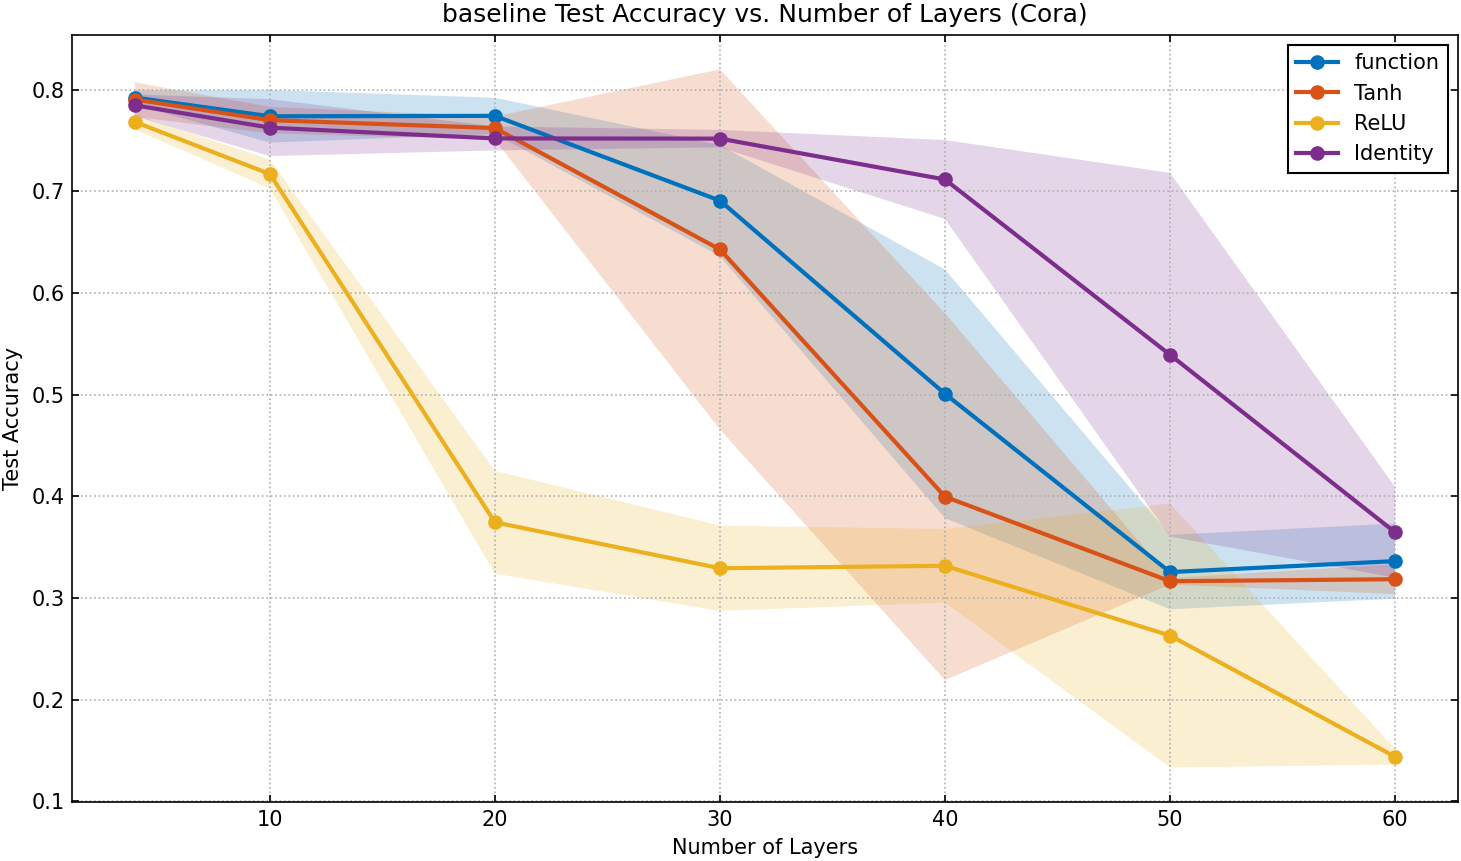


Summary of Results for Cora:
  Activation: Identity, 4 layers: 0.7846 ± 0.0107
  Activation: ReLU, 4 layers: 0.7682 ± 0.0074
  Activation: Tanh, 4 layers: 0.7902 ± 0.0170
  Activation: function, 4 layers: 0.7922 ± 0.0072
  Activation: Identity, 10 layers: 0.7626 ± 0.0280
  Activation: ReLU, 10 layers: 0.7170 ± 0.0142
  Activation: Tanh, 10 layers: 0.7700 ± 0.0130
  Activation: function, 10 layers: 0.7738 ± 0.0259
  Activation: Identity, 20 layers: 0.7520 ± 0.0118
  Activation: ReLU, 20 layers: 0.3744 ± 0.0506
  Activation: Tanh, 20 layers: 0.7622 ± 0.0114
  Activation: function, 20 layers: 0.7742 ± 0.0178
  Activation: Identity, 30 layers: 0.7518 ± 0.0086
  Activation: ReLU, 30 layers: 0.3292 ± 0.0420
  Activation: Tanh, 30 layers: 0.6428 ± 0.1771
  Activation: function, 30 layers: 0.6908 ± 0.0547
  Activation: Identity, 40 layers: 0.7116 ± 0.0388
  Activation: ReLU, 40 layers: 0.3316 ± 0.0362
  Activation: Tanh, 40 layers: 0.3996 ± 0.1804
  Activation: function, 40 layers: 0.5008 ± 0

In [33]:
plot_experiment('baseline',summary_results,layer_configs,activations)

### BO for weight variance $\sigma_w^2$

WARNING: The following cell runs BO for each combination (N_LAYERS,ACTIVATION). The results are in the following cell or can be uploaded from bo_sigma_results.pkl.

In [ ]:
# WARNING LONG EXECUTION, SKIP CELL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dictionary to store the best sigma and best accuracy for each combination.
best_sigmas = {}  # best_sigmas[num_layers][activation_name] = best sigma
best_accs = {}    # best_accs[num_layers][activation_name] = best test accuracy
# Dictionary to store full BO results for each configuration.
results_by_layers = {}

for nl in layer_configs:
    best_sigmas[nl] = {}
    best_accs[nl] = {}
    results_by_layers[nl] = {}
    for act in activations:
        act_name = act.__class__.__name__
        print(f"\n=== Running BO for {nl} layers, activation: {act_name} ===")

        # Define the objective function for the current combination.
        def objective_sigma(sigma):
            sigma_val = float(sigma)
            # For model_type 'init_gcn', pass sigma.
            acc,energy = run_experiment_dataset(
                model_type='init_gcn',
                sigma=sigma_val,
                weight_decay=0,
                num_layers=nl,
                hidden_channels=training_params["hidden_channels"],
                max_epochs=training_params["max_epochs"],
                patience=training_params["patience"],
                lr=training_params["lr"],
                activation=act,
                device=device
            )
            print(f"[{nl} layers, {act_name}] sigma={sigma_val:.3f} -> Test Accuracy={acc:.4f}, Energy:{energy:.4f}")
            return acc

        pbounds = {'sigma': (0.001, 3.0)}
        optimizer = BayesianOptimization(
            f=objective_sigma,
            pbounds=pbounds,
            random_state=seed,
        )
        optimizer.maximize(init_points=10, n_iter=15)

        # Extract best sigma and best accuracy.
        best_sigma = optimizer.max['params']['sigma']
        best_acc = optimizer.max['target']
        best_sigmas[nl][act_name] = best_sigma
        best_accs[nl][act_name] = best_acc
        results_by_layers.setdefault(nl, {})[act_name] = optimizer.res
        print(f"Best for {nl} layers, {act_name}: sigma = {best_sigma:.7f}, Test Accuracy = {best_acc:.4f}")

# Save the best results to a file so we don't lose them.
results_dict = {
    'best_sigmas': best_sigmas,
    'best_accs': best_accs,
}

for nl in best_sigmas:
    for act_name in best_sigmas[nl]:
        print(f"Layers: {nl}, Activation: {act_name} --> Best sigma: {best_sigmas[nl][act_name]:.4f}, Best Acc: {best_accs[nl][act_name]:.4f}")

with open("bo_sigma_results.pkl", "wb") as f:
    pickle.dump(results_dict, f)

print("Best sigma results saved to bo_sigma_results.pkl.")

Using device: cuda

=== Running BO for 4 layers, activation: function ===
|   iter    |  target   |   sigma   |
-------------------------------------


Processing...
Done!


Se han truncado las últimas 5000 líneas del flujo de salida.
[Cora | init_gcn | Layers: 40] Epoch: 050, Loss: 0.6317, Train: 0.8714, Val: 0.7120, Test: 0.6820
[Cora | init_gcn | Layers: 40] Epoch: 060, Loss: 0.8641, Train: 0.7143, Val: 0.6100, Test: 0.6220
[Cora | init_gcn | Layers: 40] Epoch: 070, Loss: 0.4753, Train: 0.8571, Val: 0.6820, Test: 0.6580
[Cora | init_gcn | Layers: 40] Epoch: 080, Loss: 0.3949, Train: 0.9143, Val: 0.7220, Test: 0.7060
[Cora | init_gcn | Layers: 40] Epoch: 090, Loss: 0.2985, Train: 0.9286, Val: 0.7240, Test: 0.7090
[Cora | init_gcn | Layers: 40] Epoch: 100, Loss: 0.2328, Train: 0.9571, Val: 0.7080, Test: 0.7190
[Cora | init_gcn | Layers: 40] Epoch: 110, Loss: 0.2012, Train: 0.9571, Val: 0.7120, Test: 0.7160
[Cora | init_gcn | Layers: 40] Epoch: 120, Loss: 0.1818, Train: 0.9857, Val: 0.7120, Test: 0.7200
[Cora | init_gcn | Layers: 40] Epoch: 130, Loss: 0.1747, Train: 0.9857, Val: 0.7140, Test: 0.7210
[Cora | init_gcn | Layers: 40] Epoch: 140, Loss: 0.1709, 

#### Results and plots for BO [RUN]

In [63]:
best_params = {
    4: {
        "function": {"sigma": 1.7964, "test_accuracy": 0.8150},
        "Tanh": {"sigma": 1.7964, "test_accuracy": 0.8130},
        "ReLU": {"sigma": 2.1955, "test_accuracy": 0.8130},
        "Identity": {"sigma": 2.1964, "test_accuracy": 0.8240},
    },
    10: {
        "function": {"sigma": 1.8039, "test_accuracy": 0.7970},
        "Tanh": {"sigma": 1.1259, "test_accuracy": 0.8050},
        "ReLU": {"sigma": 1.8005, "test_accuracy": 0.8070},
        "Identity": {"sigma": 2.8531, "test_accuracy": 0.8050},
    },
    20:
    {
        "function": {"sigma": 1.1232, "test_accuracy": 0.7990},
        "Tanh": {"sigma": 1.7964, "test_accuracy": 0.7970},
        "ReLU": {"sigma": 1.8394, "test_accuracy": 0.7830},
        "Identity": {"sigma": 2.8565, "test_accuracy": 0.7960},
    },
    30: {
        "function": {"sigma": 1.7971, "test_accuracy": 0.7820},
        "Tanh": {"sigma": 1.7956, "test_accuracy": 0.7810},
        "ReLU": {"sigma": 1.7864, "test_accuracy": 0.7630},
        "Identity": {"sigma": 1.7962, "test_accuracy": 0.7850},
    },
    40: {
        "function": {"sigma": 1.8037, "test_accuracy": 0.7510},
        "Tanh": {"sigma": 2.1270, "test_accuracy": 0.7440},
        "ReLU": {"sigma": 1.7964, "test_accuracy": 0.7560},
        "Identity": {"sigma": 1.1242, "test_accuracy": 0.7600},
    },
    50:
    {
        "function": {"sigma": 2.1234, "test_accuracy": 0.7220},
        "Tanh": {"sigma": 2.1231, "test_accuracy": 0.7370},
        "ReLU": {"sigma": 1.7964, "test_accuracy": 0.7160},
        "Identity": {"sigma": 2.1962, "test_accuracy": 0.7400},
    },
    60: {
        "function": {"sigma": 1.7964, "test_accuracy": 0.7190},
        "Tanh": {"sigma": 1.8037, "test_accuracy": 0.7250},
        "ReLU": {"sigma": 1.7898, "test_accuracy": 0.7180},
        "Identity": {"sigma": 2.1935, "test_accuracy": 0.7420},
    }
}
best_sigmas = {nl: {act: info['sigma'] for act, info in best_params[nl].items()} for nl in best_params}
best_accs = {nl: {act: info['test_accuracy'] for act, info in best_params[nl].items()} for nl in best_params}

In [64]:
def plot_sigmas_distr(best_sigmas, best_accs, activations, layer_configs):
    # --- Plotting: Best Test Accuracy vs. Number of Layers for each Activation ---
    plt.figure(figsize=(10, 6))
    for act in activations:
        act_name = act.__class__.__name__
        x_layers = []
        y_acc = []
        for nl in sorted(layer_configs):
            x_layers.append(nl)
            y_acc.append(best_accs[nl][act_name])
        plt.plot(x_layers, y_acc, marker='o', label=f"{act_name}")
    plt.xlabel("Number of Layers")
    plt.ylabel("Best Test Accuracy")
    plt.title("Best Test Accuracy vs. Number of Layers (Best Sigma per Activation)")
    plt.legend()
    plt.grid(True)
    plt.ylim(top=0.85, bottom=0.1)  # Set the smallest value on the y-axis to 0.1
    plt.tight_layout()
    plt.show()

    # --- Line Plot: Distribution of Best Sigma Values ---
    plt.figure(figsize=(10, 6))
    for act in activations:
        act_name = act.__class__.__name__
        x_layers = sorted(best_sigmas.keys())
        y_sigma = [best_sigmas[nl][act_name] for nl in x_layers]
        plt.plot(x_layers, y_sigma, marker='o', label=act_name)
    plt.xlabel("Number of Layers")
    plt.ylabel("Best Sigma")
    plt.title("Distribution of Best Sigma Values Across Layers")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Best sigma for each (num_layers, activation) combination:")
    for nl in sorted(best_sigmas.keys()):
        for act_name, sigma_val in best_sigmas[nl].items():
            print(f"Layers: {nl}, Activation: {act_name}  -->  Best sigma: {sigma_val}")



#### Plotting [RUN]

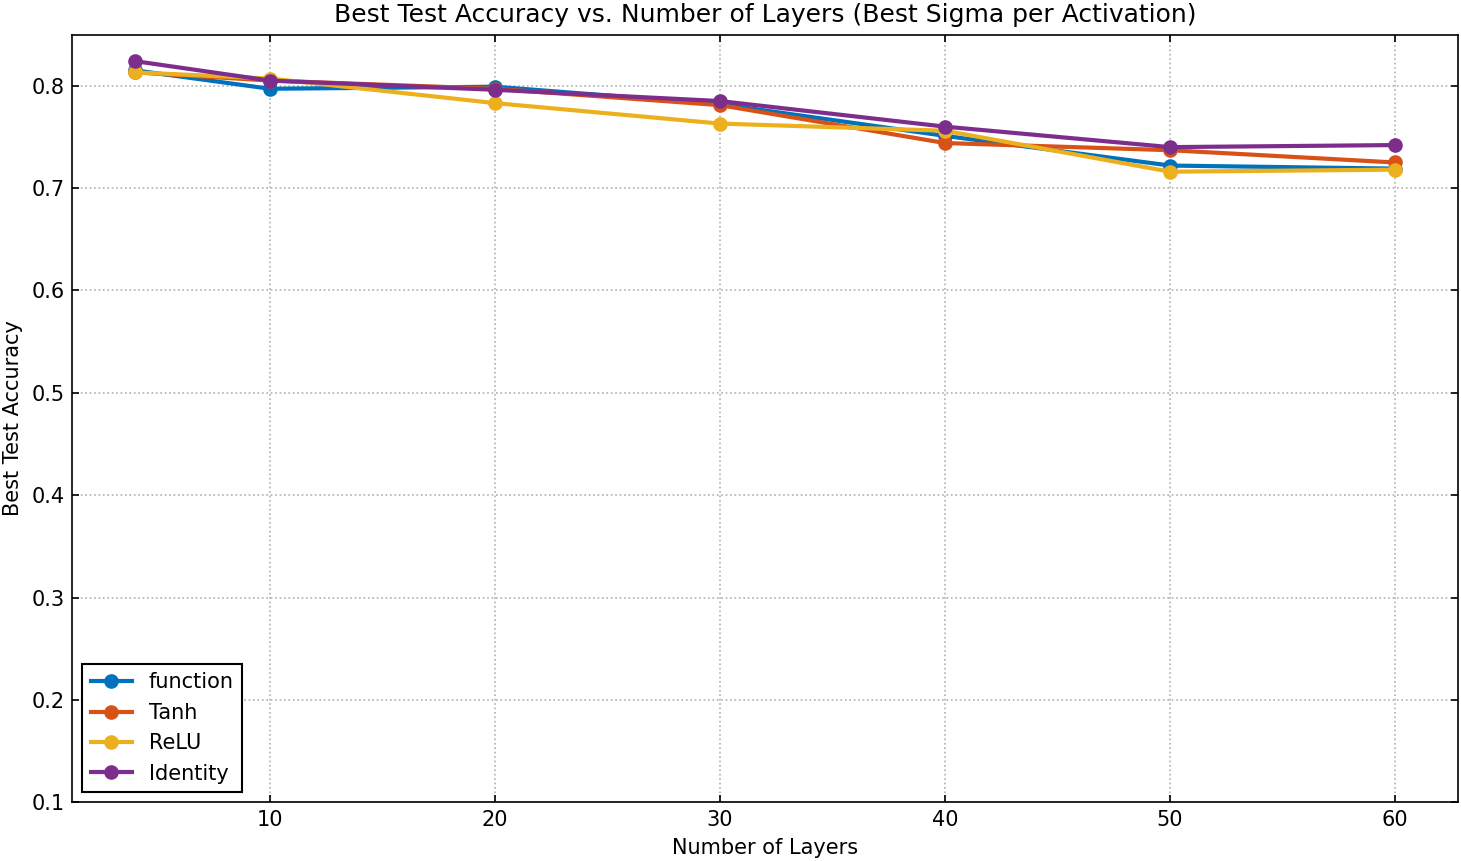

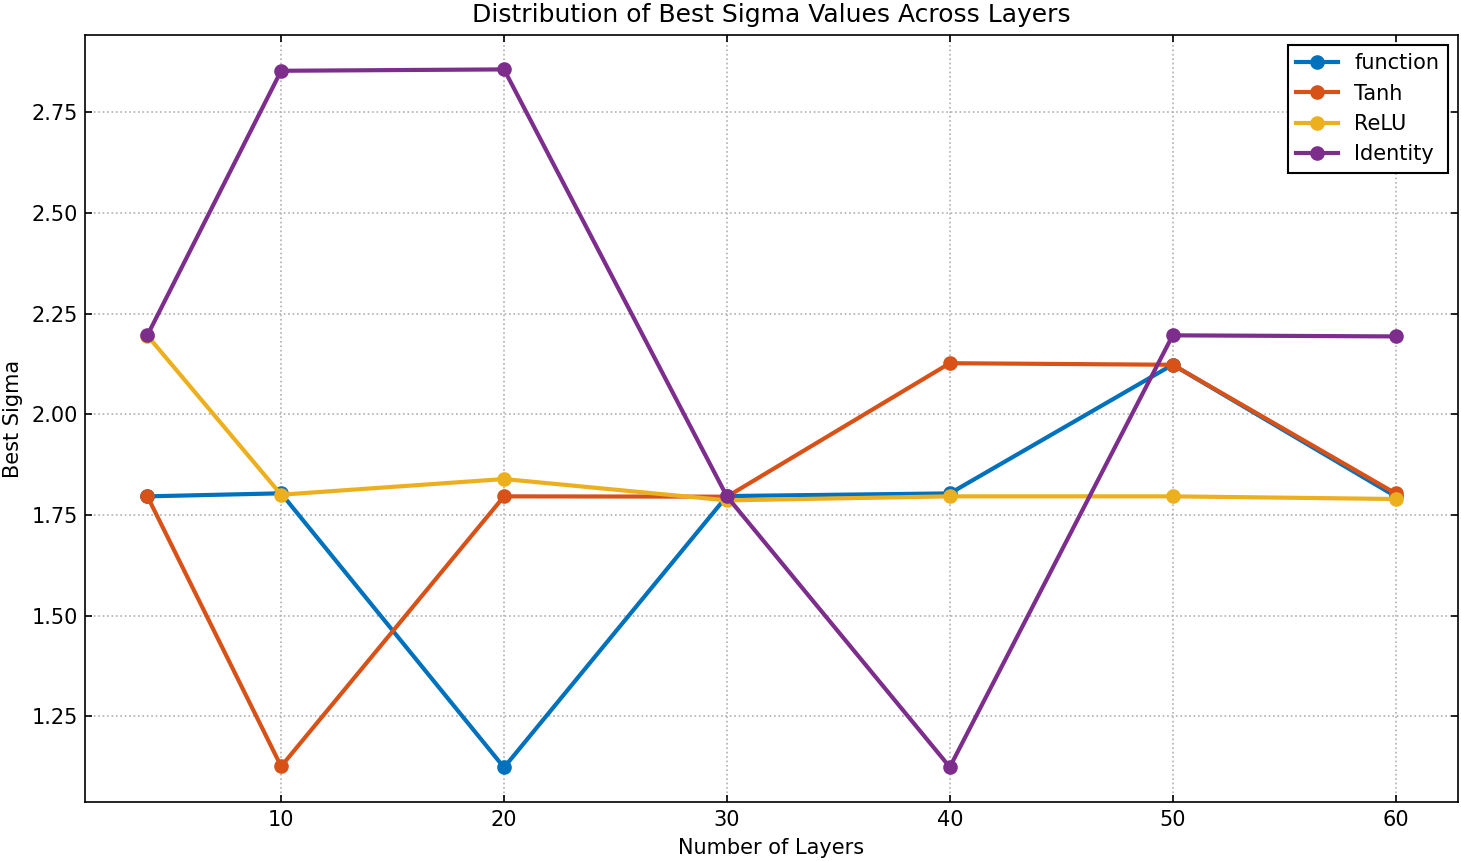

Best sigma for each (num_layers, activation) combination:
Layers: 4, Activation: function  -->  Best sigma: 1.7964
Layers: 4, Activation: Tanh  -->  Best sigma: 1.7964
Layers: 4, Activation: ReLU  -->  Best sigma: 2.1955
Layers: 4, Activation: Identity  -->  Best sigma: 2.1964
Layers: 10, Activation: function  -->  Best sigma: 1.8039
Layers: 10, Activation: Tanh  -->  Best sigma: 1.1259
Layers: 10, Activation: ReLU  -->  Best sigma: 1.8005
Layers: 10, Activation: Identity  -->  Best sigma: 2.8531
Layers: 20, Activation: function  -->  Best sigma: 1.1232
Layers: 20, Activation: Tanh  -->  Best sigma: 1.7964
Layers: 20, Activation: ReLU  -->  Best sigma: 1.8394
Layers: 20, Activation: Identity  -->  Best sigma: 2.8565
Layers: 30, Activation: function  -->  Best sigma: 1.7971
Layers: 30, Activation: Tanh  -->  Best sigma: 1.7956
Layers: 30, Activation: ReLU  -->  Best sigma: 1.7864
Layers: 30, Activation: Identity  -->  Best sigma: 1.7962
Layers: 40, Activation: function  -->  Best sigma:

In [65]:
plot_sigmas_distr(best_sigmas,best_accs,activations,layer_configs)

In [ ]:
# WARNING: THIS CELL TRAINS THE GCN 5 TIMES FOR EACH (N_LAYERS,ACTIVATION) FOR THE BEST SIGMAS
# WARNING LONG EXECUTION, SKIP CELL
summary_results = run_for_results('init_gcn',model_name='InitGCN',best_sigmas=best_sigmas,num_runs=5)

Using device: cuda
Running experiment on Cora | Activation: function | Layers: 4 | Run 1/5
[Cora | init_gcn | Layers: 4] Epoch: 000, Loss: 1.9410, Train: 0.8286, Val: 0.6060, Test: 0.6280
[Cora | init_gcn | Layers: 4] Epoch: 010, Loss: 0.2679, Train: 0.9857, Val: 0.7800, Test: 0.7940
[Cora | init_gcn | Layers: 4] Epoch: 020, Loss: 0.0545, Train: 1.0000, Val: 0.7680, Test: 0.7830
[Cora | init_gcn | Layers: 4] Epoch: 030, Loss: 0.0313, Train: 1.0000, Val: 0.7740, Test: 0.7860
[Cora | init_gcn | Layers: 4] Epoch: 040, Loss: 0.0253, Train: 1.0000, Val: 0.7760, Test: 0.7820
[Cora | init_gcn | Layers: 4] Epoch: 050, Loss: 0.0232, Train: 1.0000, Val: 0.7760, Test: 0.7810
[Cora | init_gcn | Layers: 4] Epoch: 060, Loss: 0.0223, Train: 1.0000, Val: 0.7760, Test: 0.7810
[Cora | init_gcn | Layers: 4] Epoch: 070, Loss: 0.0218, Train: 1.0000, Val: 0.7760, Test: 0.7800
[Cora | init_gcn | Layers: 4] Epoch: 080, Loss: 0.0215, Train: 1.0000, Val: 0.7760, Test: 0.7810
[Cora | init_gcn | Layers: 4] Epoch:

In [36]:
summary_results = {
      4: {'function': (0.8010, 0.0043),
          'Tanh': (0.7962, 0.0073),
          'ReLU': (0.8026, 0.0122),
          'Identity': (0.8032, 0.0069)},
      10: {'function': (0.7836, 0.0057),
          'Tanh': (0.7882, 0.0185),
           'ReLU': (0.7842, 0.0054),
          'Identity': (0.7770, 0.0091)},
      20: {'function': (0.7610, 0.0082),
           'Tanh': (0.7550, 0.0089),
           'ReLU': (0.7672, 0.0161),
           'Identity': (0.7610, 0.0208)},
      30: {'function': (0.7482, 0.0291),
           'Tanh': (0.7386, 0.0155),
           'ReLU': (0.7186, 0.0199),
           'Identity': (0.7550, 0.0101)},
      40: {'function': (0.7292, 0.0252),
           'Tanh': (0.7174, 0.0139),
           'ReLU': (0.6800, 0.0472),
           'Identity': (0.7326, 0.0327)},
      50: {'function': (0.6866, 0.0330),
           'Tanh': (0.6176, 0.1689),
           'ReLU': (0.6362, 0.0414),
           'Identity': (0.6566, 0.0551)},
      60: {'function': (0.6588, 0.0270),
           'Tanh': (0.6190, 0.0569),
           'ReLU': (0.5690, 0.0806),
           'Identity': (0.5760, 0.1384)}
  }

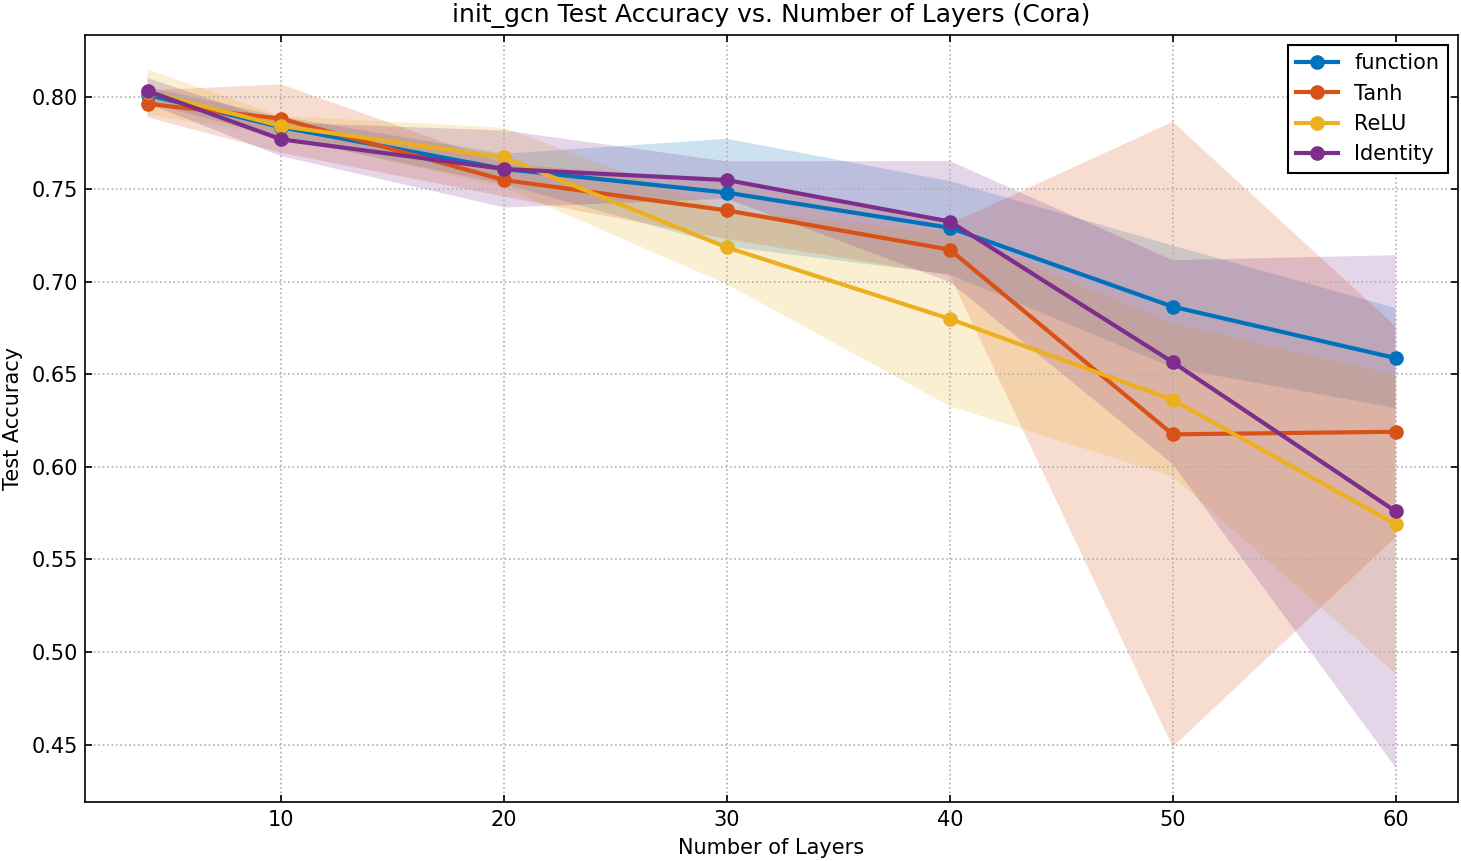


Summary of Results for Cora:
  Activation: Identity, 4 layers: 0.8032 ± 0.0069
  Activation: ReLU, 4 layers: 0.8026 ± 0.0122
  Activation: Tanh, 4 layers: 0.7962 ± 0.0073
  Activation: function, 4 layers: 0.8010 ± 0.0043
  Activation: Identity, 10 layers: 0.7770 ± 0.0091
  Activation: ReLU, 10 layers: 0.7842 ± 0.0054
  Activation: Tanh, 10 layers: 0.7882 ± 0.0185
  Activation: function, 10 layers: 0.7836 ± 0.0057
  Activation: Identity, 20 layers: 0.7610 ± 0.0208
  Activation: ReLU, 20 layers: 0.7672 ± 0.0161
  Activation: Tanh, 20 layers: 0.7550 ± 0.0089
  Activation: function, 20 layers: 0.7610 ± 0.0082
  Activation: Identity, 30 layers: 0.7550 ± 0.0101
  Activation: ReLU, 30 layers: 0.7186 ± 0.0199
  Activation: Tanh, 30 layers: 0.7386 ± 0.0155
  Activation: function, 30 layers: 0.7482 ± 0.0291
  Activation: Identity, 40 layers: 0.7326 ± 0.0327
  Activation: ReLU, 40 layers: 0.6800 ± 0.0472
  Activation: Tanh, 40 layers: 0.7174 ± 0.0139
  Activation: function, 40 layers: 0.7292 ± 0

In [37]:
plot_experiment("init_gcn",summary_results,layer_configs,activations)

### BO for OrthReg

We include the penalty $\mu||WW^T - \gamma^2 I||$ and initialized orthogonally scaling by $\gamma$.

WARNING: The following cell runs BO for $(\gamma,\mu)$ for each combination (N_LAYERS,ACTIVATION). The results are in the following cell or can be uploaded from bo_best_params_orth.pkl.

In [ ]:
# WARNING LONG EXECUTION, SKIP CELL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dictionaries to store best parameters and best accuracy for each combination.
# best_params[num_layers][activation_name] = {'gamma': best_gamma, 'orth_reg_weight': best_orth_reg_weight, 'acc': best_acc}
best_params = {}
best_accs = {}
# Dictionary to store full BO results for each configuration.
results_by_layers = {}

for nl in layer_configs:
    best_params[nl] = {}
    best_accs[nl] = {}
    results_by_layers[nl] = {}
    for act in activations:
        act_name = act.__class__.__name__
        print(f"\n=== Running BO for {nl} layers, activation: {act_name} ===")

        # Define the objective function for the current combination.
        def objective_gamma(gamma, orth_reg_weight):
            gamma_val = float(gamma)
            orth_reg_val = float(orth_reg_weight)
            # Assume run_experiment_dataset returns (test_accuracy, dirichlet_energy)
            acc,energy = run_experiment_dataset(
                model_type='orth_reg',
                gamma=gamma_val,
                num_layers=nl,
                hidden_channels=training_params["hidden_channels"],
                max_epochs=training_params["max_epochs"],
                patience=training_params["patience"],
                lr=training_params["lr"],
                weight_decay=0,
                orth_reg_weight=orth_reg_val,
                dataset_name=dataset_name,
                activation=act,
                device=device
            )
            print(f"[{nl} layers, {act_name}] gamma={gamma_val:.3f}, orth_reg_weight={orth_reg_val:.5f} -> Test Accuracy={acc:.4f}, energy: {energy:.4f}")
            return acc

        pbounds = {'gamma': (0.01, 2.0), 'orth_reg_weight': (1e-5, 1e-1)}
        optimizer = BayesianOptimization(
            f=objective_gamma,
            pbounds=pbounds,
            random_state=seed,
        )
        optimizer.maximize(init_points=10, n_iter=15)

        # Extract best parameters and best accuracy.
        best_parameters = optimizer.max['params']
        best_gamma = best_parameters['gamma']
        best_orth_reg_weight = best_parameters['orth_reg_weight']
        best_acc = optimizer.max['target']
        best_params[nl][act_name] = {
            'gamma': best_gamma,
            'orth_reg_weight': best_orth_reg_weight,
            'acc': best_acc
        }
        best_accs[nl][act_name] = best_acc
        results_by_layers.setdefault(nl, {})[act_name] = optimizer.res
        print(f"Best for {nl} layers, {act_name}: gamma = {best_gamma:.3f}, orth_reg_weight = {best_orth_reg_weight:.5f}, Test Accuracy = {best_acc:.4f}")


with open(".bo_results_orth.pkl", "wb") as f:
    pickle.dump(best_params, f)
print("Best results saved to bo_results_orth.pkl.")

In [45]:
## BEST PARAMS
best_params = {
    4: {
        "function": {"gamma": 1.338, "orth_reg_weight": 0.06422},
        "Tanh": {"gamma": 1.588, "orth_reg_weight": 0.08840},
        "ReLU": {"gamma": 0.126, "orth_reg_weight": 0.08662},
        "Identity": {"gamma": 1.759, "orth_reg_weight": 0.00079},
    },
    10: {
        "function": {"gamma": 1.667, "orth_reg_weight": 0.02124},
        "Tanh": {"gamma": 1.353, "orth_reg_weight": 0.05753},
        "ReLU": {"gamma": 1.667, "orth_reg_weight": 0.02124},
        "Identity": {"gamma": 1.465, "orth_reg_weight": 0.06031},
    },
    20: {
        "function": {"gamma": 1.806, "orth_reg_weight": 0.00061},
        "Tanh": {"gamma": 1.316, "orth_reg_weight": 0.00015},
        "ReLU": {"gamma": 1.583, "orth_reg_weight": 0.06504},
        "Identity": {"gamma": 1.864, "orth_reg_weight": 0.09743},
    },
    30: {
        "function": {"gamma": 1.329, "orth_reg_weight": 0.09774},
        "Tanh": {"gamma": 1.667, "orth_reg_weight": 0.02124},
        "ReLU": {"gamma": 1.349, "orth_reg_weight": 0.05309},
        "Identity": {"gamma": 1.206, "orth_reg_weight": 0.07081},
    },
    40: {
        "function": {"gamma": 1.695, "orth_reg_weight": 0.09975},
        "Tanh": {"gamma": 1.210, "orth_reg_weight": 0.07511},
        "ReLU": {"gamma": 1.911, "orth_reg_weight": 0.02615},
        "Identity": {"gamma": 1.910, "orth_reg_weight": 0.09944},
    },
    50: {
        "function": {"gamma": 1.905, "orth_reg_weight": 0.09949},
        "Tanh": {"gamma": 1.896, "orth_reg_weight": 0.09991},
        "ReLU": {"gamma": 1.911, "orth_reg_weight": 0.02615},
        "Identity": {"gamma": 1.122, "orth_reg_weight": 0.09702},
    },
    60: {
        "function": {"gamma": 1.467, "orth_reg_weight": 0.05987},
        "Tanh": {"gamma": 1.718, "orth_reg_weight": 0.09851},
        "ReLU": {"gamma": 0.755, "orth_reg_weight": 0.09507},
        "Identity": {"gamma": 1.787, "orth_reg_weight": 0.00124},
    },
}

In [42]:
"""with open("bo_best_params_orth.pkl", "rb") as f:
    best_params = pickle.load(f)"""

{4: {'function': {'gamma': 1.338, 'orth_reg_weight': 0.06422}, 'Tanh': {'gamma': 1.588, 'orth_reg_weight': 0.0884}, 'ReLU': {'gamma': 0.126, 'orth_reg_weight': 0.08662}, 'Identity': {'gamma': 1.759, 'orth_reg_weight': 0.00079}}, 10: {'function': {'gamma': 1.667, 'orth_reg_weight': 0.02124}, 'Tanh': {'gamma': 1.353, 'orth_reg_weight': 0.05753}, 'ReLU': {'gamma': 1.667, 'orth_reg_weight': 0.02124}, 'Identity': {'gamma': 1.465, 'orth_reg_weight': 0.06031}}, 20: {'function': {'gamma': 1.806, 'orth_reg_weight': 0.00061}, 'Tanh': {'gamma': 1.316, 'orth_reg_weight': 0.00015}, 'ReLU': {'gamma': 1.583, 'orth_reg_weight': 0.06504}, 'Identity': {'gamma': 1.864, 'orth_reg_weight': 0.09743}}, 30: {'function': {'gamma': 1.329, 'orth_reg_weight': 0.09774}, 'Tanh': {'gamma': 1.667, 'orth_reg_weight': 0.02124}, 'ReLU': {'gamma': 1.349, 'orth_reg_weight': 0.05309}, 'Identity': {'gamma': 1.206, 'orth_reg_weight': 0.07081}}, 40: {'function': {'gamma': 1.695, 'orth_reg_weight': 0.09975}, 'Tanh': {'gamma': 

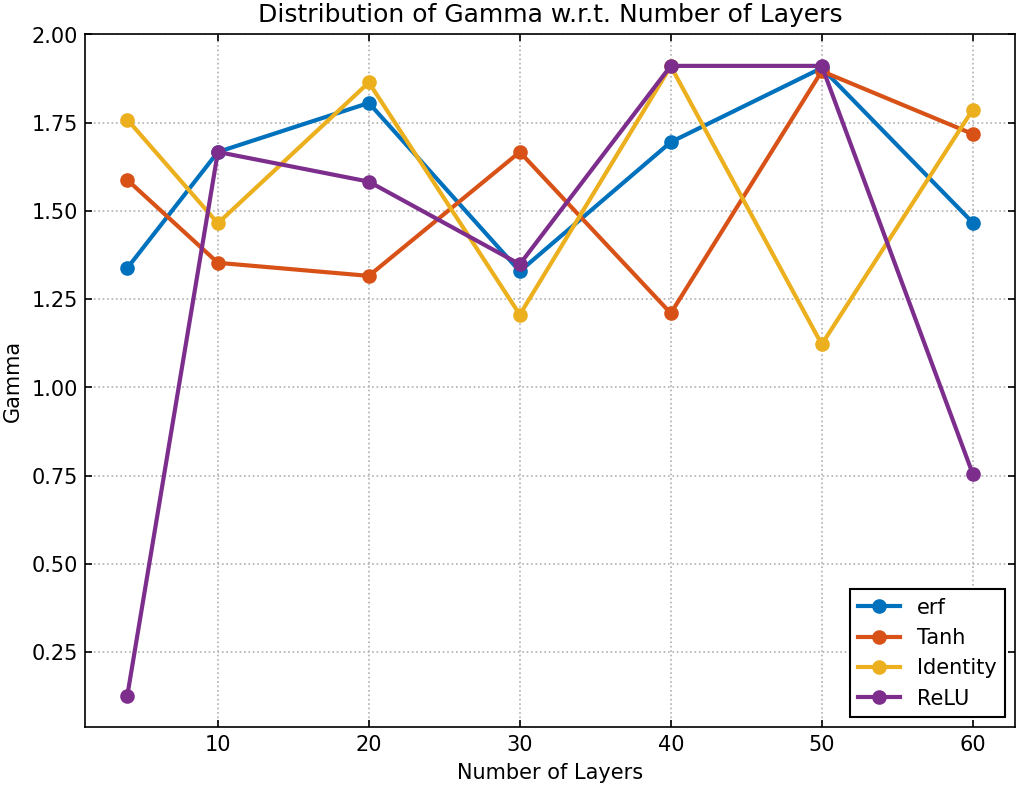

In [46]:
def plot_gammas(best_params):# Define the x-axis: the number of layers (keys of the dictionary)
  layers = sorted(best_params.keys())

  # Specify the order of activations (internally still 'function', 'Tanh', 'Identity', 'ReLU')
  activations = ["function", "Tanh", "Identity", "ReLU"]

  plt.figure(figsize=(8, 6))

  # Loop over the activation functions and plot gamma values
  for activation in activations:
      gamma_values = [best_params[layer][activation]["gamma"] for layer in layers]
      # For the legend, replace the label 'function' with 'erf'
      label = "erf" if activation == "function" else activation
      plt.plot(layers, gamma_values, marker='o', label=label)

  plt.xlabel("Number of Layers")
  plt.ylabel("Gamma")
  plt.title("Distribution of Gamma w.r.t. Number of Layers")
  plt.legend()
  plt.grid(True)
  plt.show()

plot_gammas(best_params)

In [ ]:
# WARNING LONG EXECUTION, SKIP CELL
summary_results = run_for_results('orth_reg',dataset_name='Cora',best_orth_params=best_params,num_runs=5)
print(summary_results)

Using device: cpu
Running experiment on Cora | Activation: function | Layers: 4 | Run 1/5
[Cora | orth_reg | Layers: 4] Epoch: 000, Loss: 22.4811, Train: 0.4500, Val: 0.3500, Test: 0.3950
[Cora | orth_reg | Layers: 4] Epoch: 010, Loss: 13.6029, Train: 0.9286, Val: 0.7440, Test: 0.7540
[Cora | orth_reg | Layers: 4] Epoch: 020, Loss: 6.9151, Train: 0.9571, Val: 0.7800, Test: 0.8040
[Cora | orth_reg | Layers: 4] Epoch: 030, Loss: 2.9122, Train: 0.9786, Val: 0.7860, Test: 0.8050
[Cora | orth_reg | Layers: 4] Epoch: 040, Loss: 0.9779, Train: 1.0000, Val: 0.7740, Test: 0.8010
[Cora | orth_reg | Layers: 4] Epoch: 050, Loss: 0.4253, Train: 1.0000, Val: 0.7780, Test: 0.7990
[Cora | orth_reg | Layers: 4] Epoch: 060, Loss: 0.2724, Train: 1.0000, Val: 0.7760, Test: 0.7960
[Cora | orth_reg | Layers: 4] Epoch: 070, Loss: 0.2195, Train: 1.0000, Val: 0.7780, Test: 0.7940
[Cora | orth_reg | Layers: 4] Epoch: 080, Loss: 0.1977, Train: 1.0000, Val: 0.7780, Test: 0.7930
[Cora | orth_reg | Layers: 4] Epoch

In [48]:
summary_results = {4: {'Identity': (0.8068, 0.0055),
     'ReLU': (0.7532, 0.043),
     'Tanh': (0.8046, 0.003),
     'function': (0.8038, 0.0051)},
 10: {'Identity': (0.8046, 0.0048),
      'ReLU': (0.787, 0.0076),
      'Tanh': (0.7964, 0.0067),
      'function': (0.8054, 0.0046)},
 20: {'Identity': (0.7896, 0.003),
      'ReLU': (0.4576, 0.2698),
      'Tanh': (0.7834, 0.0146),
      'function': (0.7876, 0.0149)},
 30: {'Identity': (0.7864, 0.0106),
      'ReLU': (0.2772, 0.1999),
      'Tanh': (0.7896, 0.0045),
      'function': (0.7898, 0.0078)},
 40: {'Identity': (0.7808, 0.0111),
      'ReLU': (0.176, 0.0808),
      'Tanh': (0.792, 0.0065),
      'function': (0.7918, 0.0126)},
 50: {'Identity': (0.7766, 0.0084),
      'ReLU': (0.265, 0.2126),
      'Tanh': (0.7886, 0.0067),
      'function': (0.7852, 0.0112)},
 60: {'Identity': (0.7456, 0.0247),
      'ReLU': (0.1754, 0.0805),
      'Tanh': (0.7796, 0.0151),
      'function': (0.7918, 0.0088)}}

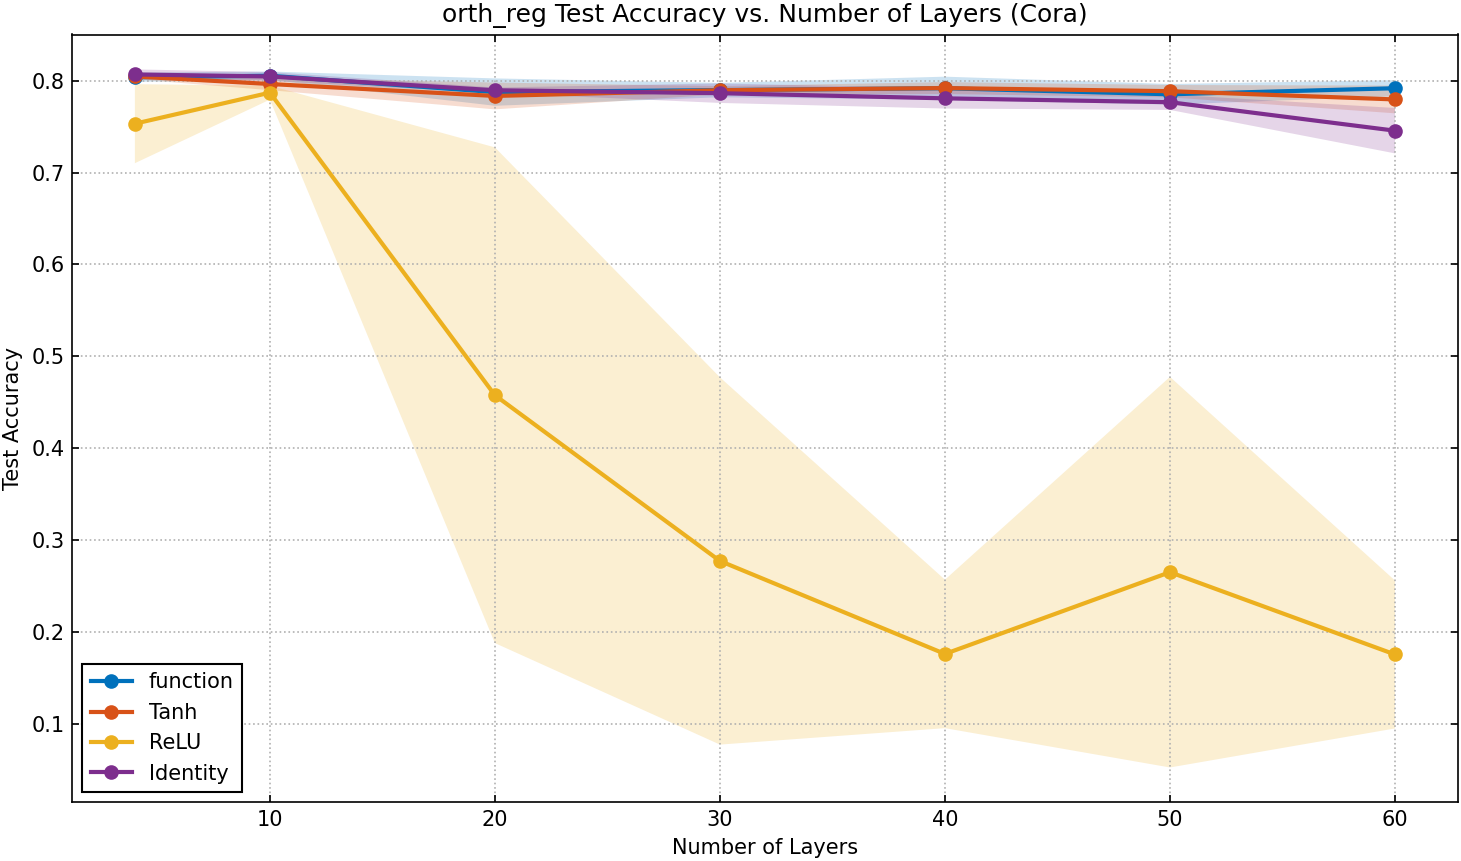


Summary of Results for Cora:
  Activation: Identity, 4 layers: 0.8068 ± 0.0055
  Activation: ReLU, 4 layers: 0.7532 ± 0.0430
  Activation: Tanh, 4 layers: 0.8046 ± 0.0030
  Activation: function, 4 layers: 0.8038 ± 0.0051
  Activation: Identity, 10 layers: 0.8046 ± 0.0048
  Activation: ReLU, 10 layers: 0.7870 ± 0.0076
  Activation: Tanh, 10 layers: 0.7964 ± 0.0067
  Activation: function, 10 layers: 0.8054 ± 0.0046
  Activation: Identity, 20 layers: 0.7896 ± 0.0030
  Activation: ReLU, 20 layers: 0.4576 ± 0.2698
  Activation: Tanh, 20 layers: 0.7834 ± 0.0146
  Activation: function, 20 layers: 0.7876 ± 0.0149
  Activation: Identity, 30 layers: 0.7864 ± 0.0106
  Activation: ReLU, 30 layers: 0.2772 ± 0.1999
  Activation: Tanh, 30 layers: 0.7896 ± 0.0045
  Activation: function, 30 layers: 0.7898 ± 0.0078
  Activation: Identity, 40 layers: 0.7808 ± 0.0111
  Activation: ReLU, 40 layers: 0.1760 ± 0.0808
  Activation: Tanh, 40 layers: 0.7920 ± 0.0065
  Activation: function, 40 layers: 0.7918 ± 0

In [49]:
plot_experiment('orth_reg',summary_results,layer_configs,activations)

## Ablation studies

In this section we perform ablation studies for OrthRegGCN.

### Orthogonal no penalty ($\mu = 0,\gamma = 1)$.

In [ ]:
# WARNING LONG EXECUTION, SKIP CELL
params = {}
for nl in layer_configs:
    params[nl] = {}
    for act in activations:
        act_name = act.__class__.__name__
        params[nl][act_name] = {'gamma': 1.0, 'orth_reg_weight': 0}
summary_results = run_for_results('orth_reg',"no-gamma-no-mu",dataset_name='Cora',best_orth_params=params,num_runs=5)
print(summary_results)

In [50]:
summary_results = {
    4: {
        "function": (0.8002, 0.0073),
        "Tanh":     (0.7996, 0.0113),
        "ReLU":     (0.7870, 0.0203),
        "Identity": (0.8060, 0.0037)
    },
    10: {
        "function": (0.7834, 0.0152),
        "Tanh":     (0.7768, 0.0118),
        "ReLU":     (0.7512, 0.0143),
        "Identity": (0.7776, 0.0118)
    },
    20: {
        "function": (0.7774, 0.0110),
        "Tanh":     (0.7782, 0.0104),
        "ReLU":     (0.2622, 0.0969),
        "Identity": (0.7874, 0.0079)
    },
    30: {
        "function": (0.7738, 0.0149),
        "Tanh":     (0.7728, 0.0134),
        "ReLU":     (0.2926, 0.0891),
        "Identity": (0.7642, 0.0109)
    },
    40: {
        "function": (0.7216, 0.0576),
        "Tanh":     (0.7058, 0.0913),
        "ReLU":     (0.2952, 0.0797),
        "Identity": (0.6652, 0.0916)
    },
    50: {
        "function": (0.4366, 0.0463),
        "Tanh":     (0.4638, 0.0903),
        "ReLU":     (0.2240, 0.1045),
        "Identity": (0.6212, 0.0747)
    },
    60: {
        "function": (0.3658, 0.0547),
        "Tanh":     (0.3950, 0.0737),
        "ReLU":     (0.1760, 0.0802),
        "Identity": (0.4582, 0.0725)
    }
}

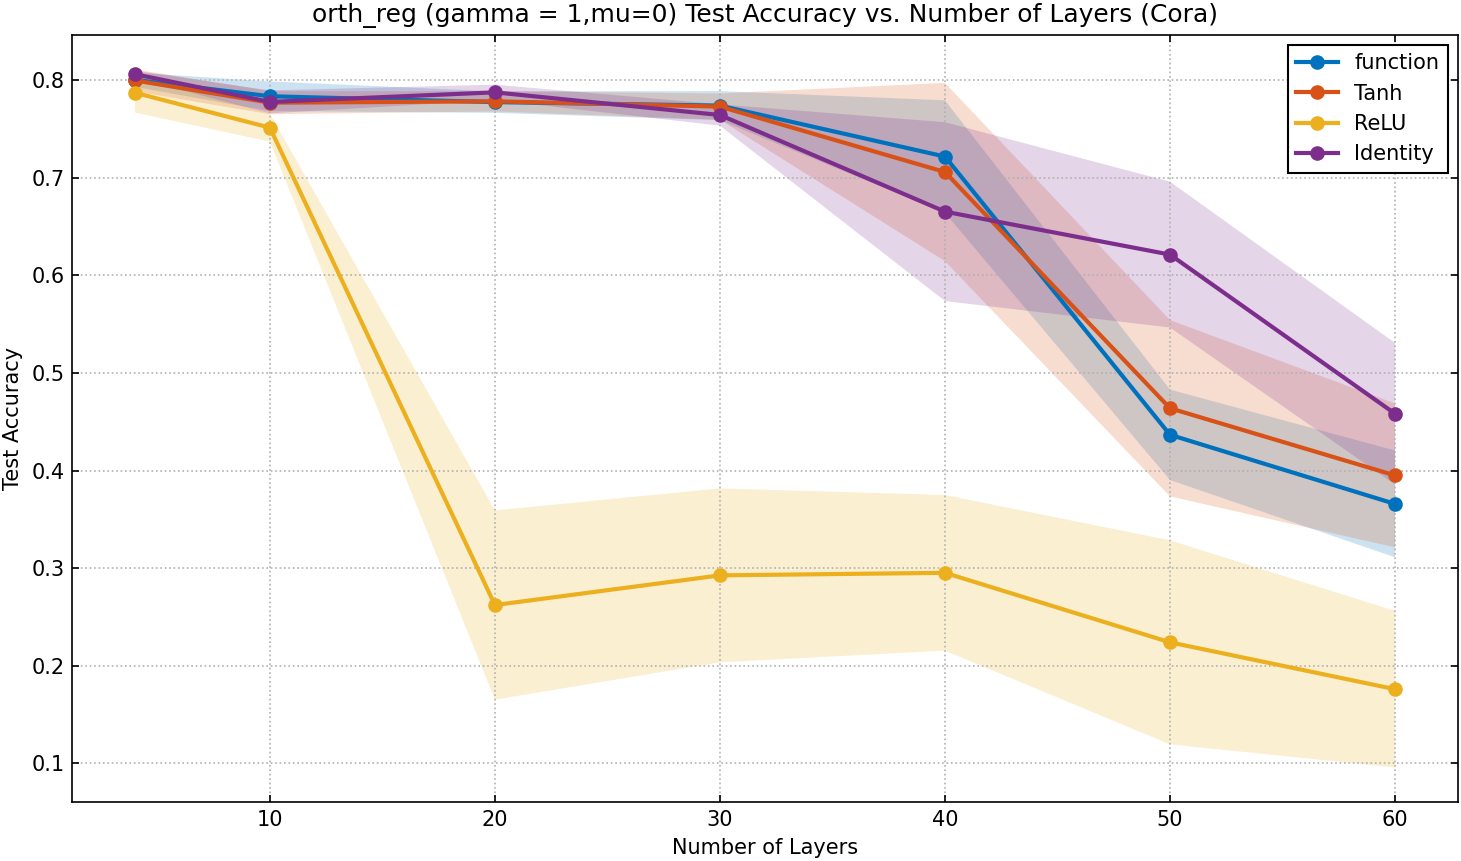


Summary of Results for Cora:
  Activation: Identity, 4 layers: 0.8060 ± 0.0037
  Activation: ReLU, 4 layers: 0.7870 ± 0.0203
  Activation: Tanh, 4 layers: 0.7996 ± 0.0113
  Activation: function, 4 layers: 0.8002 ± 0.0073
  Activation: Identity, 10 layers: 0.7776 ± 0.0118
  Activation: ReLU, 10 layers: 0.7512 ± 0.0143
  Activation: Tanh, 10 layers: 0.7768 ± 0.0118
  Activation: function, 10 layers: 0.7834 ± 0.0152
  Activation: Identity, 20 layers: 0.7874 ± 0.0079
  Activation: ReLU, 20 layers: 0.2622 ± 0.0969
  Activation: Tanh, 20 layers: 0.7782 ± 0.0104
  Activation: function, 20 layers: 0.7774 ± 0.0110
  Activation: Identity, 30 layers: 0.7642 ± 0.0109
  Activation: ReLU, 30 layers: 0.2926 ± 0.0891
  Activation: Tanh, 30 layers: 0.7728 ± 0.0134
  Activation: function, 30 layers: 0.7738 ± 0.0149
  Activation: Identity, 40 layers: 0.6652 ± 0.0916
  Activation: ReLU, 40 layers: 0.2952 ± 0.0797
  Activation: Tanh, 40 layers: 0.7058 ± 0.0913
  Activation: function, 40 layers: 0.7216 ± 0

In [51]:
plot_experiment('orth_reg (gamma = 1,mu=0)',summary_results,layer_configs,activations)

### Only penalty ($\gamma=1$, BO for $\mu$, penalty $\mu ||WW^T - I ||$)

WARNING LONG EXECUTION IN THE FOLLOWING CELL

In [ ]:
# WARNING LONG EXECUTION, SKIP CELL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dictionaries to store best parameters and best accuracy for each combination.
# best_params[num_layers][activation_name] = {'gamma': best_gamma, 'orth_reg_weight': best_orth_reg_weight, 'acc': best_acc}
best_params = {}
best_accs = {}
# Dictionary to store full BO results for each configuration.
results_by_layers = {}

for nl in layer_configs:
    best_params[nl] = {}
    best_accs[nl] = {}
    results_by_layers[nl] = {}
    for act in activations:
        act_name = act.__class__.__name__
        print(f"\n=== Running BO for {nl} layers, activation: {act_name} ===")

        # Define the objective function for the current combination.
        def objective_gamma(orth_reg_weight):
            orth_reg_val = float(orth_reg_weight)
            # Assume run_experiment_dataset returns (test_accuracy, dirichlet_energy)
            acc,energy = run_experiment_dataset(
                model_type='orth_reg',
                gamma=1.0,
                num_layers=nl,
                hidden_channels=training_params["hidden_channels"],
                max_epochs=training_params["max_epochs"],
                patience=training_params["patience"],
                lr=training_params["lr"],
                weight_decay=0,
                orth_reg_weight=orth_reg_val,
                dataset_name='Cora',
                activation=act,
                device=device
            )
            print(f"[{nl} layers, {act_name}] orth_reg_weight={orth_reg_val:.5f} -> Test Accuracy={acc:.4f}, energy: {energy:.4f}")
            return acc

        pbounds = {'orth_reg_weight': (1e-5, 1e-1)}
        optimizer = BayesianOptimization(
            f=objective_gamma,
            pbounds=pbounds,
            random_state=seed,
        )
        optimizer.maximize(init_points=10, n_iter=15)

        # Extract best parameters and best accuracy.
        best_parameters = optimizer.max['params']
        best_orth_reg_weight = best_parameters['orth_reg_weight']
        best_acc = optimizer.max['target']
        best_params[nl][act_name] = {
            'orth_reg_weight': best_orth_reg_weight,
            'acc': best_acc
        }
        best_accs[nl][act_name] = best_acc
        results_by_layers.setdefault(nl, {})[act_name] = optimizer.res
        print(f"Best for {nl} layers, {act_name}: orth_reg_weight = {best_orth_reg_weight:.5f}, Test Accuracy = {best_acc:.4f}")

# Save the best results to a file.
results_dict = {
    'best_params': best_params,
    'best_accs': best_accs,
    'results_by_layers': results_by_layers
}
with open("bo_results_orth-only-penalty.pkl", "wb") as f:
    pickle.dump(results_dict, f)
print("Best results saved to bo_results_orth.only-penalty.pkl.")



Using device: cuda

=== Running BO for 60 layers, activation: function ===
|   iter    |  target   | orth_r... |
-------------------------------------


Processing...
Done!


[Cora | orth_reg | Layers: 60] Epoch: 000, Loss: 287.9790, Train: 0.1929, Val: 0.2120, Test: 0.2130
[Cora | orth_reg | Layers: 60] Epoch: 010, Loss: 177.1877, Train: 0.1857, Val: 0.1600, Test: 0.1730
[Cora | orth_reg | Layers: 60] Epoch: 020, Loss: 136.6640, Train: 0.1500, Val: 0.1160, Test: 0.1400
[Cora | orth_reg | Layers: 60] Epoch: 030, Loss: 121.6978, Train: 0.1643, Val: 0.1220, Test: 0.1460
[Cora | orth_reg | Layers: 60] Epoch: 040, Loss: 115.0796, Train: 0.1643, Val: 0.1240, Test: 0.1410
[Cora | orth_reg | Layers: 60] Epoch: 050, Loss: 111.8457, Train: 0.1571, Val: 0.1180, Test: 0.1420
[Cora | orth_reg | Layers: 60] Epoch: 060, Loss: 110.1824, Train: 0.1643, Val: 0.1180, Test: 0.1420
[Cora | orth_reg | Layers: 60] Epoch: 070, Loss: 109.3057, Train: 0.1643, Val: 0.1180, Test: 0.1420
[Cora | orth_reg | Layers: 60] Epoch: 080, Loss: 108.8391, Train: 0.1643, Val: 0.1180, Test: 0.1420
[Cora | orth_reg | Layers: 60] Epoch: 090, Loss: 108.5899, Train: 0.1643, Val: 0.1180, Test: 0.1420


In [52]:
best_params = {
    4: {
        "function": {"orth_reg_weight": 0.01556, "test_accuracy": 0.8120},
        "Tanh": {"orth_reg_weight": 0.05986, "test_accuracy": 0.8170},
        "ReLU": {"orth_reg_weight": 0.09506, "test_accuracy": 0.8140},
        "Identity": {"orth_reg_weight": 0.01561, "test_accuracy": 0.8150},
    },
    10: {
        "function": {"orth_reg_weight": 0.01561, "test_accuracy": 0.8170},
        "Tanh": {"orth_reg_weight": 0.01557, "test_accuracy": 0.8120},
        "ReLU": {"orth_reg_weight": 0.07071, "test_accuracy": 0.8020},
        "Identity": {"orth_reg_weight": 0.01560, "test_accuracy": 0.8130},
    },
    20: {
        "function": {"orth_reg_weight": 0.01561, "test_accuracy": 0.8080},
        "Tanh": {"orth_reg_weight": 0.00582, "test_accuracy": 0.7980},
        "ReLU": {"orth_reg_weight": 0.07320, "test_accuracy": 0.6450},
        "Identity": {"orth_reg_weight": 0.06014, "test_accuracy": 0.7940},
    },
    30: {
        "function": {"orth_reg_weight": 0.01561, "test_accuracy": 0.7970},
        "Tanh": {"orth_reg_weight": 0.00583, "test_accuracy": 0.7930},
        "ReLU": {"orth_reg_weight": 0.09509, "test_accuracy": 0.3190},
        "Identity": {"orth_reg_weight": 0.07077, "test_accuracy": 0.7840},
    },
    40: {
        "function": {"orth_reg_weight": 0.07272, "test_accuracy": 0.7880},
        "Tanh": {"orth_reg_weight": 0.07081, "test_accuracy": 0.7820},
        "ReLU": {"orth_reg_weight": 0.01561, "test_accuracy": 0.3190},
        "Identity": {"orth_reg_weight": 0.07081, "test_accuracy": 0.7720},
    },
    50: {
        "function": {"orth_reg_weight": 0.05987, "test_accuracy": 0.7810},
        "Tanh": {"orth_reg_weight": 0.09509, "test_accuracy": 0.7580},
        "ReLU": {"orth_reg_weight": 0.08640, "test_accuracy": 0.3190},
        "Identity": {"orth_reg_weight": 0.07077, "test_accuracy": 0.7440},
    },
    60: {
        "function": {"orth_reg_weight": 0.09509, "test_accuracy": 0.7660},
        "Tanh": {"orth_reg_weight": 0.8671,  "test_accuracy": 0.7820},
        "ReLU": {"orth_reg_weight": 0.01561, "test_accuracy": 0.3190},
        "Identity": {"orth_reg_weight": 0.05987, "test_accuracy": 0.7440},
    },
}


In [ ]:
print("Best parameters for each (num_layers, activation) combination:")
for nl in sorted(best_params.keys()):
    for act_name, params in best_params[nl].items():
        print(f"Layers: {nl}, Activation: {act_name}  -->  Best orth_reg_weight: {params['orth_reg_weight']:.5f}, Acc: {params['test_accuracy']:.4f}")

Best parameters for each (num_layers, activation) combination:
Layers: 4, Activation: function  -->  Best orth_reg_weight: 0.01556, Acc: 0.8120
Layers: 4, Activation: Tanh  -->  Best orth_reg_weight: 0.05986, Acc: 0.8170
Layers: 4, Activation: ReLU  -->  Best orth_reg_weight: 0.09506, Acc: 0.8140
Layers: 4, Activation: Identity  -->  Best orth_reg_weight: 0.01561, Acc: 0.8150
Layers: 10, Activation: function  -->  Best orth_reg_weight: 0.01561, Acc: 0.8170
Layers: 10, Activation: Tanh  -->  Best orth_reg_weight: 0.01557, Acc: 0.8120
Layers: 10, Activation: ReLU  -->  Best orth_reg_weight: 0.07071, Acc: 0.8020
Layers: 10, Activation: Identity  -->  Best orth_reg_weight: 0.01560, Acc: 0.8130
Layers: 20, Activation: function  -->  Best orth_reg_weight: 0.01561, Acc: 0.8080
Layers: 20, Activation: Tanh  -->  Best orth_reg_weight: 0.00582, Acc: 0.7980
Layers: 20, Activation: ReLU  -->  Best orth_reg_weight: 0.07320, Acc: 0.6450
Layers: 20, Activation: Identity  -->  Best orth_reg_weight: 0.

In [ ]:
# WARNING LONG EXECUTION, SKIP CELL
params = {}
for nl in layer_configs:
    params[nl] = {}
    for act in activations:
        act_name = act.__class__.__name__
        params[nl][act_name] = {'gamma': 1.0, 'orth_reg_weight': best_params[nl][act_name]['orth_reg_weight']}
summary_results = run_for_results('orth_reg',dataset_name='Cora',best_orth_params=params,num_runs=5)
print(summary_results)

Using device: cuda
Running experiment on Cora | Activation: function | Layers: 4 | Run 1/5
[Cora | orth_reg | Layers: 4] Epoch: 000, Loss: 1.9491, Train: 0.3143, Val: 0.2140, Test: 0.2370
[Cora | orth_reg | Layers: 4] Epoch: 010, Loss: 1.3401, Train: 0.9571, Val: 0.7700, Test: 0.7780
[Cora | orth_reg | Layers: 4] Epoch: 020, Loss: 0.7901, Train: 0.9714, Val: 0.7880, Test: 0.8000
[Cora | orth_reg | Layers: 4] Epoch: 030, Loss: 0.5516, Train: 0.9857, Val: 0.7820, Test: 0.8010
[Cora | orth_reg | Layers: 4] Epoch: 040, Loss: 0.4694, Train: 0.9857, Val: 0.7800, Test: 0.8030
[Cora | orth_reg | Layers: 4] Epoch: 050, Loss: 0.4353, Train: 0.9929, Val: 0.7820, Test: 0.8040
[Cora | orth_reg | Layers: 4] Epoch: 060, Loss: 0.4196, Train: 0.9929, Val: 0.7820, Test: 0.8030
[Cora | orth_reg | Layers: 4] Epoch: 070, Loss: 0.4118, Train: 0.9929, Val: 0.7820, Test: 0.8040
[Cora | orth_reg | Layers: 4] Epoch: 080, Loss: 0.4080, Train: 0.9929, Val: 0.7820, Test: 0.8040
[Cora | orth_reg | Layers: 4] Epoch:

In [53]:
summary_results = {
    4: {
        "function": (0.7988, 0.0062),
        "Tanh":     (0.7994, 0.0015),
        "ReLU":     (0.8028, 0.0041),
        "Identity": (0.8056, 0.0035)
    },
    10: {
        "function": (0.7936, 0.0102),
        "Tanh":     (0.7940, 0.0111),
        "ReLU":     (0.7876, 0.0040),
        "Identity": (0.7950, 0.0091)
    },
    20: {
        "function": (0.7884, 0.0072),
        "Tanh":     (0.7902, 0.0087),
        "ReLU":     (0.2948, 0.2534),
        "Identity": (0.7684, 0.0086)
    },
    30: {
        "function": (0.7776, 0.0130),
        "Tanh":     (0.7878, 0.0056),
        "ReLU":     (0.1822, 0.0791),
        "Identity": (0.7582, 0.0086)
    },
    40: {
        "function": (0.7526, 0.0188),
        "Tanh":     (0.7466, 0.0239),
        "ReLU":     (0.1994, 0.0606),
        "Identity": (0.7398, 0.0227)
    },
    50: {
        "function": (0.7314, 0.0064),
        "Tanh":     (0.7430, 0.0311),
        "ReLU":     (0.1820, 0.0768),
        "Identity": (0.5226, 0.0695)
    },
    60: {
        "function": (0.7460, 0.0265),
        "Tanh":     (0.7200, 0.0149),
        "ReLU":     (0.1896, 0.0758),
        "Identity": (0.5062, 0.0998)
    }
}

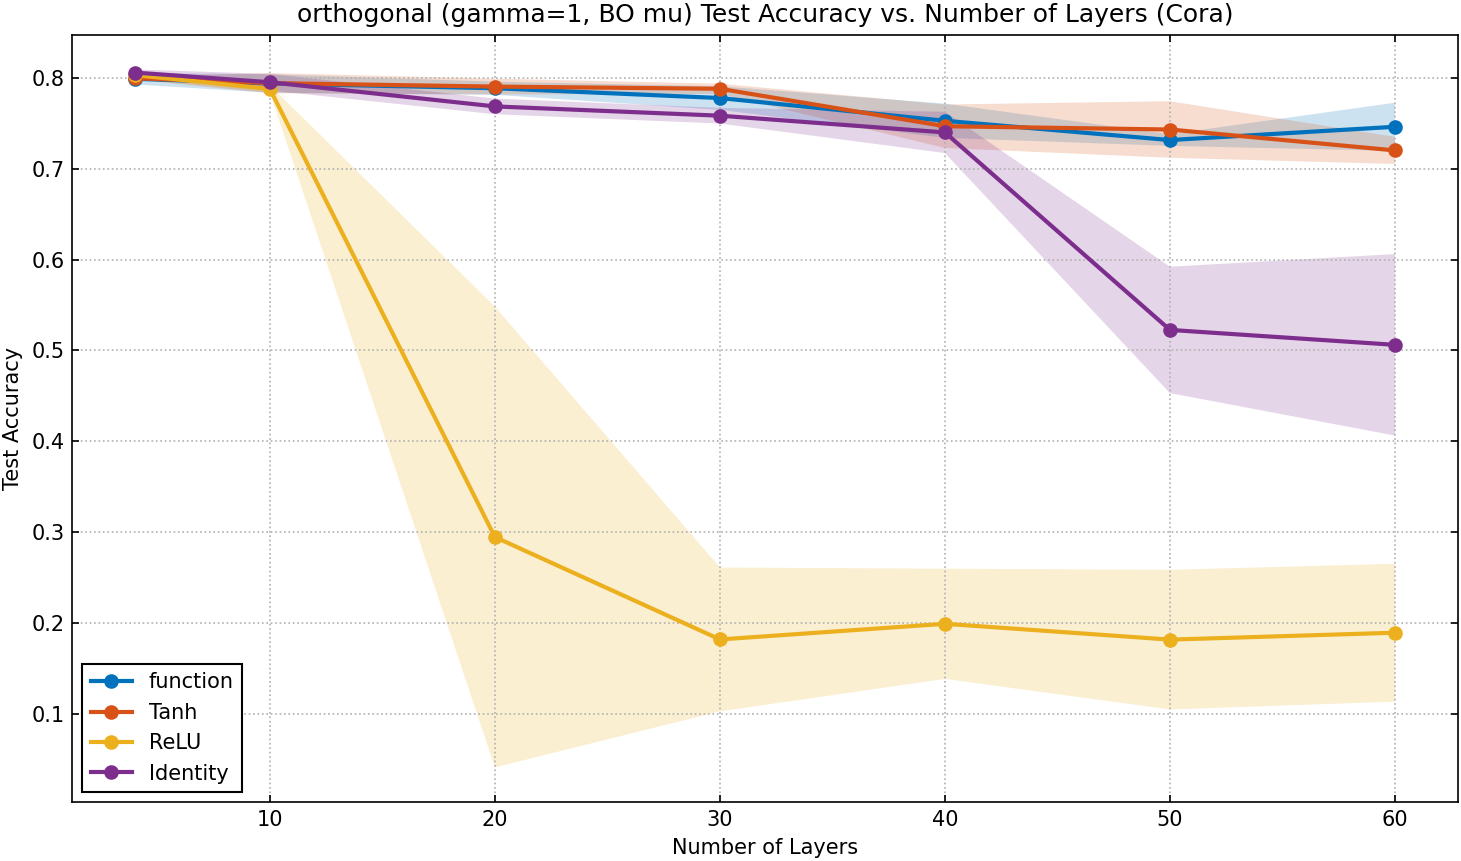


Summary of Results for Cora:
  Activation: Identity, 4 layers: 0.8056 ± 0.0035
  Activation: ReLU, 4 layers: 0.8028 ± 0.0041
  Activation: Tanh, 4 layers: 0.7994 ± 0.0015
  Activation: function, 4 layers: 0.7988 ± 0.0062
  Activation: Identity, 10 layers: 0.7950 ± 0.0091
  Activation: ReLU, 10 layers: 0.7876 ± 0.0040
  Activation: Tanh, 10 layers: 0.7940 ± 0.0111
  Activation: function, 10 layers: 0.7936 ± 0.0102
  Activation: Identity, 20 layers: 0.7684 ± 0.0086
  Activation: ReLU, 20 layers: 0.2948 ± 0.2534
  Activation: Tanh, 20 layers: 0.7902 ± 0.0087
  Activation: function, 20 layers: 0.7884 ± 0.0072
  Activation: Identity, 30 layers: 0.7582 ± 0.0086
  Activation: ReLU, 30 layers: 0.1822 ± 0.0791
  Activation: Tanh, 30 layers: 0.7878 ± 0.0056
  Activation: function, 30 layers: 0.7776 ± 0.0130
  Activation: Identity, 40 layers: 0.7398 ± 0.0227
  Activation: ReLU, 40 layers: 0.1994 ± 0.0606
  Activation: Tanh, 40 layers: 0.7466 ± 0.0239
  Activation: function, 40 layers: 0.7526 ± 0

In [54]:
plot_experiment("orthogonal (gamma=1, BO mu)",summary_results,layer_configs,activations)

### Only gamma (no penalty ie $\mu=0$)

WARNING LONG EXECUTION IN THE FOLLOWING CELL, SKIP IT

In [ ]:
# WARNING LONG EXECUTION
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dictionaries to store best parameters and best accuracy for each combination.
# best_params[num_layers][activation_name] = {'gamma': best_gamma, 'orth_reg_weight': best_orth_reg_weight, 'acc': best_acc}
best_params = {}
best_accs = {}
# Dictionary to store full BO results for each configuration.
results_by_layers = {}

for nl in layer_configs:
    best_params[nl] = {}
    best_accs[nl] = {}
    results_by_layers[nl] = {}
    for act in activations:
        act_name = act.__class__.__name__
        print(f"\n=== Running BO for {nl} layers, activation: {act_name} ===")

        # Define the objective function for the current combination.
        def objective_gamma(gamma):
            gamma_val = float(gamma)
            # Assume run_experiment_dataset returns (test_accuracy, dirichlet_energy)
            acc,energy = run_experiment_dataset(
                model_type='orth_reg',
                gamma=gamma_val,
                num_layers=nl,
                hidden_channels=training_params["hidden_channels"],
                max_epochs=training_params["max_epochs"],
                patience=training_params["patience"],
                lr=training_params["lr"],
                weight_decay=0,
                orth_reg_weight=0,
                dataset_name='Cora',
                activation=act,
                device=device
            )
            print(f"[{nl} layers, {act_name}] gamma={gamma_val:.3f} -> Test Accuracy={acc:.4f}, energy: {energy:.4f}")
            return acc

        pbounds = {'gamma': (0.01, 2.0)}
        optimizer = BayesianOptimization(
            f=objective_gamma,
            pbounds=pbounds,
            random_state=seed,
        )
        optimizer.maximize(init_points=10, n_iter=15)

        # Extract best parameters and best accuracy.
        best_parameters = optimizer.max['params']
        best_gamma = best_parameters['gamma']
        best_acc = optimizer.max['target']
        best_params[nl][act_name] = {
            'gamma': best_gamma,
            'acc': best_acc
        }
        best_accs[nl][act_name] = best_acc
        results_by_layers.setdefault(nl, {})[act_name] = optimizer.res
        print(f"Best for {nl} layers, {act_name}: gamma = {best_gamma:.3f}, Test Accuracy = {best_acc:.4f}")

# Save the best results to a file.
results_dict = {
    'best_params': best_params,
    'best_accs': best_accs,
    'results_by_layers': results_by_layers
}


Using device: cpu

=== Running BO for 50 layers, activation: function ===
|   iter    |  target   |   gamma   |
-------------------------------------


Processing...
Done!


[Cora | orth_reg | Layers: 50] Epoch: 000, Loss: 1.9474, Train: 0.2214, Val: 0.1720, Test: 0.1670
[Cora | orth_reg | Layers: 50] Epoch: 010, Loss: 1.8357, Train: 0.1714, Val: 0.1520, Test: 0.1530
[Cora | orth_reg | Layers: 50] Epoch: 020, Loss: 1.4161, Train: 0.4429, Val: 0.5220, Test: 0.5070
[Cora | orth_reg | Layers: 50] Epoch: 030, Loss: 1.1683, Train: 0.5000, Val: 0.5040, Test: 0.4810
[Cora | orth_reg | Layers: 50] Epoch: 040, Loss: 1.0786, Train: 0.6000, Val: 0.5740, Test: 0.5540
[Cora | orth_reg | Layers: 50] Epoch: 050, Loss: 1.0052, Train: 0.6357, Val: 0.6020, Test: 0.5940
[Cora | orth_reg | Layers: 50] Epoch: 060, Loss: 0.9283, Train: 0.7143, Val: 0.6080, Test: 0.6090
[Cora | orth_reg | Layers: 50] Epoch: 070, Loss: 0.8604, Train: 0.7214, Val: 0.6280, Test: 0.6300
[Cora | orth_reg | Layers: 50] Epoch: 080, Loss: 0.8112, Train: 0.7143, Val: 0.6300, Test: 0.6500
[Cora | orth_reg | Layers: 50] Epoch: 090, Loss: 0.8153, Train: 0.8000, Val: 0.6320, Test: 0.6720
[Cora | orth_reg | L

In [55]:
best_params = {
    4: {
        "function": {"gamma": 0.320, "test_accuracy": 0.8150},
        "Tanh": {"gamma": 1.734, "test_accuracy": 0.8110},
        "ReLU": {"gamma": 0.126, "test_accuracy": 0.8070},
        "Identity": {"gamma": 1.206, "test_accuracy": 0.8240},
    },
    10: {
        "function": {"gamma": 0.126, "test_accuracy": 0.8010},
        "Tanh": {"gamma": 1.201, "test_accuracy": 0.8070},
        "ReLU": {"gamma": 1.205, "test_accuracy": 0.7740},
        "Identity": {"gamma": 1.734, "test_accuracy": 0.8130},
    },
    20: {
        "function": {"gamma": 1.419, "test_accuracy": 0.8010},
        "Tanh": {"gamma": 1.419, "test_accuracy": 0.7990},
        "ReLU": {"gamma": 0.321, "test_accuracy": 0.4110},
        "Identity": {"gamma": 1.419, "test_accuracy": 0.7960},
    },
    30: {
        "function": {"gamma": 1.419, "test_accuracy": 0.7870},
        "Tanh": {"gamma": 1.201, "test_accuracy": 0.8100},
        "ReLU": {"gamma": 0.126, "test_accuracy": 0.4250},
        "Identity": {"gamma": 0.320, "test_accuracy": 0.7820},
    },
    40: {
        "function": {"gamma": 1.419, "test_accuracy": 0.7780},
        "Tanh": {"gamma": 1.201, "test_accuracy": 0.7560},
        "ReLU": {"gamma": 0.755, "test_accuracy": 0.4630},
        "Identity": {"gamma": 1.206, "test_accuracy": 0.7680},
    },
    50: {
        "function": {"gamma": 0.755, "test_accuracy":0.7170},
        "Tanh": {"gamma": 1.734, "test_accuracy": 0.6830},
        "ReLU": {"gamma": 1.734, "test_accuracy": 0.4260},
        "Identity": {"gamma": 1.203, "test_accuracy": 0.7670}
    },
    60: {
        "function": {"gamma": 0.320, "test_accuracy": 0.4590},
        "Tanh": {"gamma": 1.206, "test_accuracy": 0.5150},
        "ReLU": {"gamma": 0.755, "test_accuracy": 0.3190},
        "Identity": {"gamma": 1.467, "test_accuracy": 0.7490}
    }

}

In [ ]:
# WARNING LONG EXECUTION, SKIP CELL
params = {}
for nl in layer_configs:
    params[nl] = {}
    for act in activations:
        act_name = act.__class__.__name__
        params[nl][act_name] = {'gamma': best_params[nl][act_name]['gamma'], 'orth_reg_weight': 0.0}
summary_results = run_for_results('orth_reg',dataset_name='Cora',best_orth_params=params,num_runs=5)
print(summary_results)

Using device: cuda
Running experiment on Cora | Activation: function | Layers: 4 | Run 1/5


Processing...
Done!


[Cora | orth_reg | Layers: 4] Epoch: 000, Loss: 1.9476, Train: 0.5071, Val: 0.4160, Test: 0.4450
[Cora | orth_reg | Layers: 4] Epoch: 010, Loss: 1.1213, Train: 0.9143, Val: 0.7360, Test: 0.7600
[Cora | orth_reg | Layers: 4] Epoch: 020, Loss: 0.2032, Train: 0.9786, Val: 0.7980, Test: 0.8120
[Cora | orth_reg | Layers: 4] Epoch: 030, Loss: 0.0331, Train: 1.0000, Val: 0.7660, Test: 0.7910
[Cora | orth_reg | Layers: 4] Epoch: 040, Loss: 0.0139, Train: 1.0000, Val: 0.7540, Test: 0.7840
[Cora | orth_reg | Layers: 4] Epoch: 050, Loss: 0.0099, Train: 1.0000, Val: 0.7640, Test: 0.7840
[Cora | orth_reg | Layers: 4] Epoch: 060, Loss: 0.0087, Train: 1.0000, Val: 0.7680, Test: 0.7850
[Cora | orth_reg | Layers: 4] Epoch: 070, Loss: 0.0083, Train: 1.0000, Val: 0.7680, Test: 0.7850
[Cora | orth_reg | Layers: 4] Epoch: 080, Loss: 0.0080, Train: 1.0000, Val: 0.7680, Test: 0.7850
[Cora | orth_reg | Layers: 4] Epoch: 090, Loss: 0.0079, Train: 1.0000, Val: 0.7680, Test: 0.7850
[Cora | orth_reg | Layers: 4] 

In [56]:
summary_results = {
    4: {'Identity': (0.8068, 0.0055),
     'ReLU': (0.7532, 0.043),
     'Tanh': (0.8046, 0.003),
     'function': (0.8038, 0.0051)},
 10: {'Identity': (0.8046, 0.0048),
      'ReLU': (0.787, 0.0076),
      'Tanh': (0.7964, 0.0067),
      'function': (0.8054, 0.0046)},
 20: {'Identity': (0.7896, 0.003),
      'ReLU': (0.4576, 0.2698),
      'Tanh': (0.7834, 0.0146),
      'function': (0.7876, 0.0149)},
 30: {'Identity': (0.7864, 0.0106),
      'ReLU': (0.2772, 0.1999),
      'Tanh': (0.7896, 0.0045),
      'function': (0.7898, 0.0078)},
 40: {'Identity': (0.7808, 0.0111),
      'ReLU': (0.176, 0.0808),
      'Tanh': (0.792, 0.0065),
      'function': (0.7918, 0.0126)},
 50: {'Identity': (0.7766, 0.0084),
      'ReLU': (0.265, 0.2126),
      'Tanh': (0.7886, 0.0067),
      'function': (0.7852, 0.0112)},
 60: {'Identity': (0.7456, 0.0247),
      'ReLU': (0.1754, 0.0805),
      'Tanh': (0.7796, 0.0151),
      'function': (0.7918, 0.0088)}
}

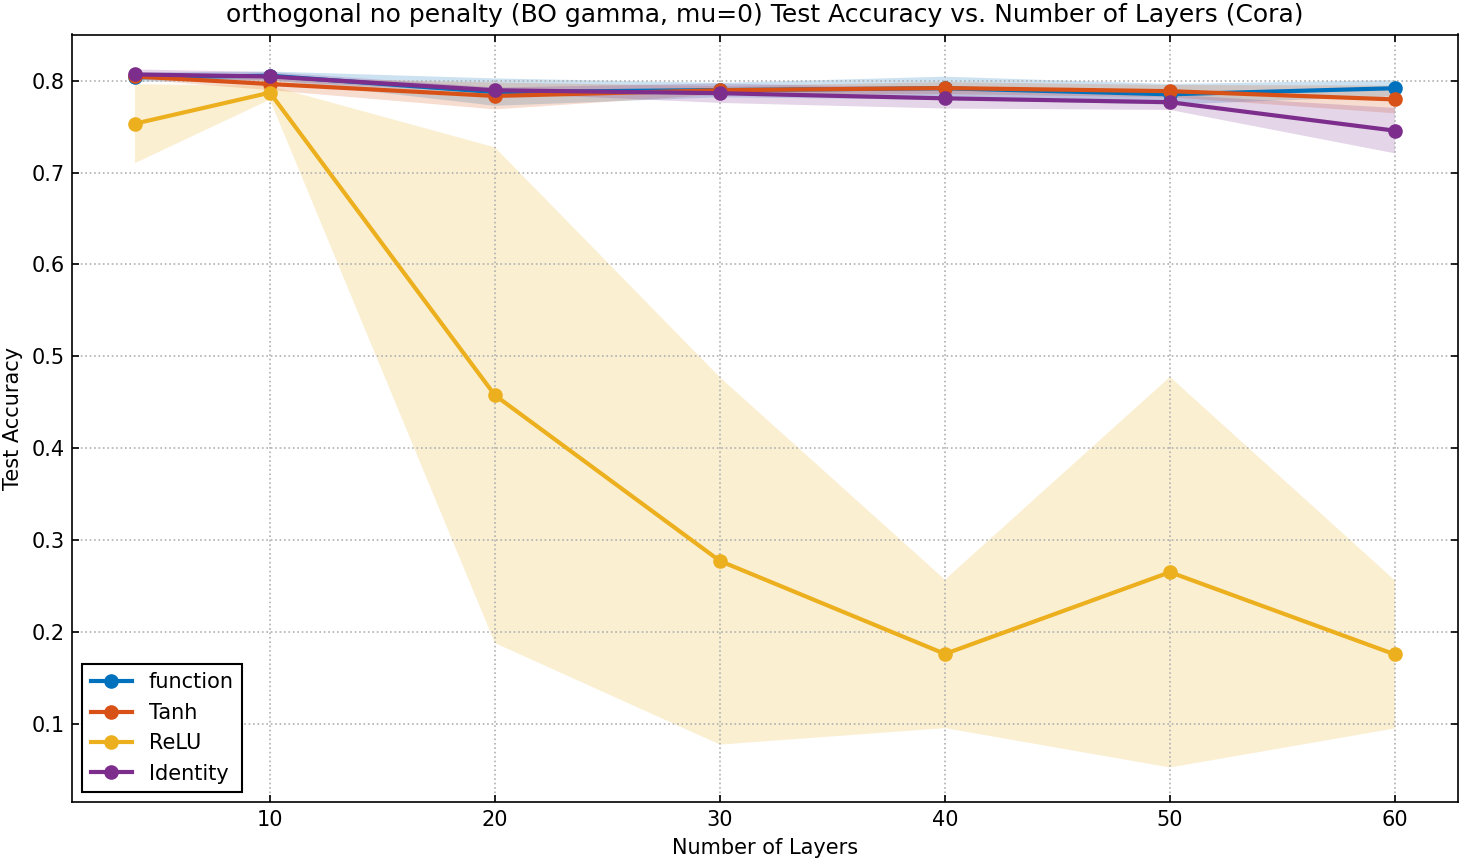


Summary of Results for Cora:
  Activation: Identity, 4 layers: 0.8068 ± 0.0055
  Activation: ReLU, 4 layers: 0.7532 ± 0.0430
  Activation: Tanh, 4 layers: 0.8046 ± 0.0030
  Activation: function, 4 layers: 0.8038 ± 0.0051
  Activation: Identity, 10 layers: 0.8046 ± 0.0048
  Activation: ReLU, 10 layers: 0.7870 ± 0.0076
  Activation: Tanh, 10 layers: 0.7964 ± 0.0067
  Activation: function, 10 layers: 0.8054 ± 0.0046
  Activation: Identity, 20 layers: 0.7896 ± 0.0030
  Activation: ReLU, 20 layers: 0.4576 ± 0.2698
  Activation: Tanh, 20 layers: 0.7834 ± 0.0146
  Activation: function, 20 layers: 0.7876 ± 0.0149
  Activation: Identity, 30 layers: 0.7864 ± 0.0106
  Activation: ReLU, 30 layers: 0.2772 ± 0.1999
  Activation: Tanh, 30 layers: 0.7896 ± 0.0045
  Activation: function, 30 layers: 0.7898 ± 0.0078
  Activation: Identity, 40 layers: 0.7808 ± 0.0111
  Activation: ReLU, 40 layers: 0.1760 ± 0.0808
  Activation: Tanh, 40 layers: 0.7920 ± 0.0065
  Activation: function, 40 layers: 0.7918 ± 0

In [57]:
plot_experiment("orthogonal no penalty (BO gamma, mu=0)",summary_results,layer_configs,activations)

## Final results and plots

### Dictionaries with ablation results and plotting functions [RUN]

In [60]:
import pprint

# Dictionary for configuration: orthogonal gamma=1, mu=0
orthogonal_gamma1_mu0 = {
    4: {
        "function": (0.8002, 0.0073),
        "Tanh":     (0.7996, 0.0113),
        "ReLU":     (0.7870, 0.0203),
        "Identity": (0.8060, 0.0037)
    },
    10: {
        "function": (0.7834, 0.0152),
        "Tanh":     (0.7768, 0.0118),
        "ReLU":     (0.7512, 0.0143),
        "Identity": (0.7776, 0.0118)
    },
    20: {
        "function": (0.7774, 0.0110),
        "Tanh":     (0.7782, 0.0104),
        "ReLU":     (0.2622, 0.0969),
        "Identity": (0.7874, 0.0079)
    },
    30: {
        "function": (0.7738, 0.0149),
        "Tanh":     (0.7728, 0.0134),
        "ReLU":     (0.2926, 0.0891),
        "Identity": (0.7642, 0.0109)
    },
    40: {
        "function": (0.7216, 0.0576),
        "Tanh":     (0.7058, 0.0913),
        "ReLU":     (0.2952, 0.0797),
        "Identity": (0.6652, 0.0916)
    },
    50: {
        "function": (0.4366, 0.0463),
        "Tanh":     (0.4638, 0.0903),
        "ReLU":     (0.2240, 0.1045),
        "Identity": (0.6212, 0.0747)
    },
    60: {
        "function": (0.3658, 0.0547),
        "Tanh":     (0.3950, 0.0737),
        "ReLU":     (0.1760, 0.0802),
        "Identity": (0.4582, 0.0725)
    }
}

# Dictionary for configuration: orthogonal BO gamma, mu=0
orthogonal_BO_gamma_mu0 = {
    4: {
        "function": (0.8002, 0.0073),
        "Tanh":     (0.7996, 0.0113),
        "ReLU":     (0.7870, 0.0203),
        "Identity": (0.8060, 0.0037)
    },
    10: {
        "function": (0.7834, 0.0152),
        "Tanh":     (0.7768, 0.0118),
        "ReLU":     (0.7476, 0.0207),
        "Identity": (0.7776, 0.0118)
    },
    20: {
        "function": (0.7774, 0.0110),
        "Tanh":     (0.7782, 0.0104),
        "ReLU":     (0.2698, 0.0942),
        "Identity": (0.7874, 0.0079)
    },
    30: {
        "function": (0.7738, 0.0149),
        "Tanh":     (0.7728, 0.0134),
        "ReLU":     (0.2986, 0.0906),
        "Identity": (0.7646, 0.0115)
    },
    40: {
        "function": (0.7460, 0.0246),
        "Tanh":     (0.7036, 0.0900),
        "ReLU":     (0.2834, 0.0738),
        "Identity": (0.6660, 0.0925)
    },
    50: {
        "function": (0.4532, 0.0580),
        "Tanh":     (0.4612, 0.0979),
        "ReLU":     (0.2302, 0.1038),
        "Identity": (0.6184, 0.0734)
    },
    60: {
        "function": (0.3506, 0.0612),
        "Tanh":     (0.3722, 0.0527),
        "ReLU":     (0.1772, 0.0795),
        "Identity": (0.4714, 0.0874)
    }
}

# Dictionary for configuration: orthogonal gamma=1, BO mu
orthogonal_gamma1_BO_mu = {
    4: {
        "function": (0.7988, 0.0062),
        "Tanh":     (0.7994, 0.0015),
        "ReLU":     (0.8028, 0.0041),
        "Identity": (0.8056, 0.0035)
    },
    10: {
        "function": (0.7936, 0.0102),
        "Tanh":     (0.7940, 0.0111),
        "ReLU":     (0.7876, 0.0040),
        "Identity": (0.7950, 0.0091)
    },
    20: {
        "function": (0.7884, 0.0072),
        "Tanh":     (0.7902, 0.0087),
        "ReLU":     (0.2948, 0.2534),
        "Identity": (0.7684, 0.0086)
    },
    30: {
        "function": (0.7776, 0.0130),
        "Tanh":     (0.7878, 0.0056),
        "ReLU":     (0.1822, 0.0791),
        "Identity": (0.7582, 0.0086)
    },
    40: {
        "function": (0.7526, 0.0188),
        "Tanh":     (0.7466, 0.0239),
        "ReLU":     (0.1994, 0.0606),
        "Identity": (0.7398, 0.0227)
    },
    50: {
        "function": (0.7314, 0.0064),
        "Tanh":     (0.7430, 0.0311),
        "ReLU":     (0.1820, 0.0768),
        "Identity": (0.5226, 0.0695)
    },
    60: {
        "function": (0.7460, 0.0265),
        "Tanh":     (0.7200, 0.0149),
        "ReLU":     (0.1896, 0.0758),
        "Identity": (0.5062, 0.0998)
    }
}

# Dictionary for configuration: BO gamma, BO mu
BO_gamma_BO_mu = {
    4: {
        "function": (0.8038, 0.0051),
        "Tanh":     (0.8046, 0.0030),
        "ReLU":     (0.7532, 0.0430),
        "Identity": (0.8068, 0.0055)
    },
    10: {
        "function": (0.8054, 0.0046),
        "Tanh":     (0.7964, 0.0067),
        "ReLU":     (0.7870, 0.0076),
        "Identity": (0.8046, 0.0048)
    },
    20: {
        "function": (0.7876, 0.0149),
        "Tanh":     (0.7834, 0.0146),
        "ReLU":     (0.4576, 0.2698),
        "Identity": (0.7896, 0.0030)
    },
    30: {
        "function": (0.7898, 0.0078),
        "Tanh":     (0.7896, 0.0045),
        "ReLU":     (0.2772, 0.1999),
        "Identity": (0.7864, 0.0106)
    },
    40: {
        "function": (0.7918, 0.0126),
        "Tanh":     (0.7920, 0.0065),
        "ReLU":     (0.1760, 0.0808),
        "Identity": (0.7808, 0.0111)
    },
    50: {
        "function": (0.7852, 0.0112),
        "Tanh":     (0.7886, 0.0067),
        "ReLU":     (0.2650, 0.2126),
        "Identity": (0.7766, 0.0084)
    },
    60: {
        "function": (0.7918, 0.0088),
        "Tanh":     (0.7796, 0.0151),
        "ReLU":     (0.1754, 0.0805),
        "Identity": (0.7456, 0.0247)
    }
}

# Optionally, print the dictionaries to verify their contents.
print("orthogonal gamma=1, mu=0:")
pprint.pprint(orthogonal_gamma1_mu0)
print("\northogonal BO gamma, mu=0:")
pprint.pprint(orthogonal_BO_gamma_mu0)
print("\northogonal gamma=1, BO mu:")
pprint.pprint(orthogonal_gamma1_BO_mu)
print("\nBO gamma, BO mu:")
pprint.pprint(BO_gamma_BO_mu)


orthogonal gamma=1, mu=0:
{4: {'Identity': (0.806, 0.0037),
     'ReLU': (0.787, 0.0203),
     'Tanh': (0.7996, 0.0113),
     'function': (0.8002, 0.0073)},
 10: {'Identity': (0.7776, 0.0118),
      'ReLU': (0.7512, 0.0143),
      'Tanh': (0.7768, 0.0118),
      'function': (0.7834, 0.0152)},
 20: {'Identity': (0.7874, 0.0079),
      'ReLU': (0.2622, 0.0969),
      'Tanh': (0.7782, 0.0104),
      'function': (0.7774, 0.011)},
 30: {'Identity': (0.7642, 0.0109),
      'ReLU': (0.2926, 0.0891),
      'Tanh': (0.7728, 0.0134),
      'function': (0.7738, 0.0149)},
 40: {'Identity': (0.6652, 0.0916),
      'ReLU': (0.2952, 0.0797),
      'Tanh': (0.7058, 0.0913),
      'function': (0.7216, 0.0576)},
 50: {'Identity': (0.6212, 0.0747),
      'ReLU': (0.224, 0.1045),
      'Tanh': (0.4638, 0.0903),
      'function': (0.4366, 0.0463)},
 60: {'Identity': (0.4582, 0.0725),
      'ReLU': (0.176, 0.0802),
      'Tanh': (0.395, 0.0737),
      'function': (0.3658, 0.0547)}}

orthogonal BO gamma, mu=

In [61]:
def plot_activation(activation):
    """
    Plots the results (mean and uncertainty) as a function of the number of layers
    for a given activation function from all 4 configurations.
    """
    # Combine the 4 dictionaries into one dictionary mapping configuration name to its dictionary.
    config_dicts = {
        "No scaling, no penalty (γ=1, μ=0)": orthogonal_gamma1_mu0,
        "Scaling, no penalty (BO γ, μ=0)": orthogonal_BO_gamma_mu0,
        "No scaling, penalty (γ=1, BO μ)": orthogonal_gamma1_BO_mu,
        "OrthRegGCN (BO for γ,μ)": BO_gamma_BO_mu
    }

    plt.figure(figsize=(8, 6))

    # Iterate over each configuration and plot its line and error band.
    for label, data in config_dicts.items():
        layers = sorted(data.keys())  # list of layer numbers
        # Extract means and uncertainties for the given activation function
        means = [data[layer][activation][0] for layer in layers]
        errors = [data[layer][activation][1] for layer in layers]
        x = np.array(layers)
        y = np.array(means)
        err = np.array(errors)

        # Plot the line with markers
        plt.plot(x, y, marker='o', label=label)
        # Shade the area between (mean - error) and (mean + error)
        plt.fill_between(x, y - err, y + err, alpha=0.2)

    plt.xlabel("Number of Layers")
    plt.ylabel("Test Accuracy")
    activation_name = activation if activation != "function" else "erf"
    plt.title(f"Results for Activation: {activation_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_all_activations():
    """
    Loops over all activation functions and creates a separate plot for each one.
    """
    activations = ["function", "Tanh", "ReLU", "Identity"]
    for act in activations:
        plot_activation(act)


### Plot

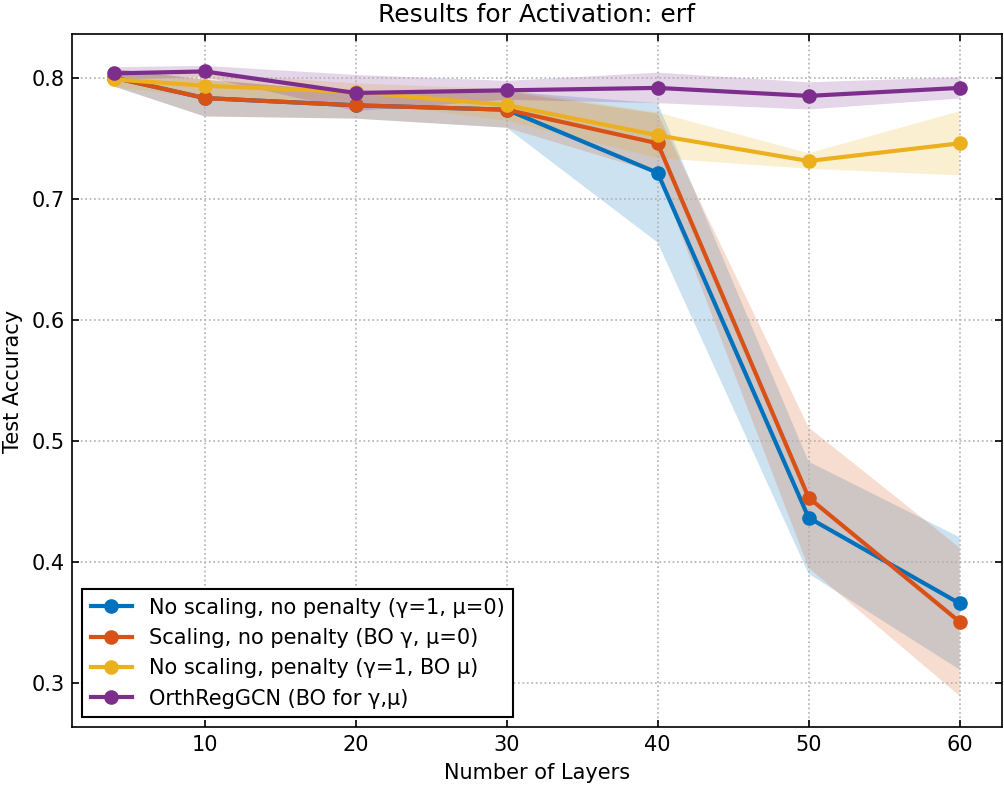

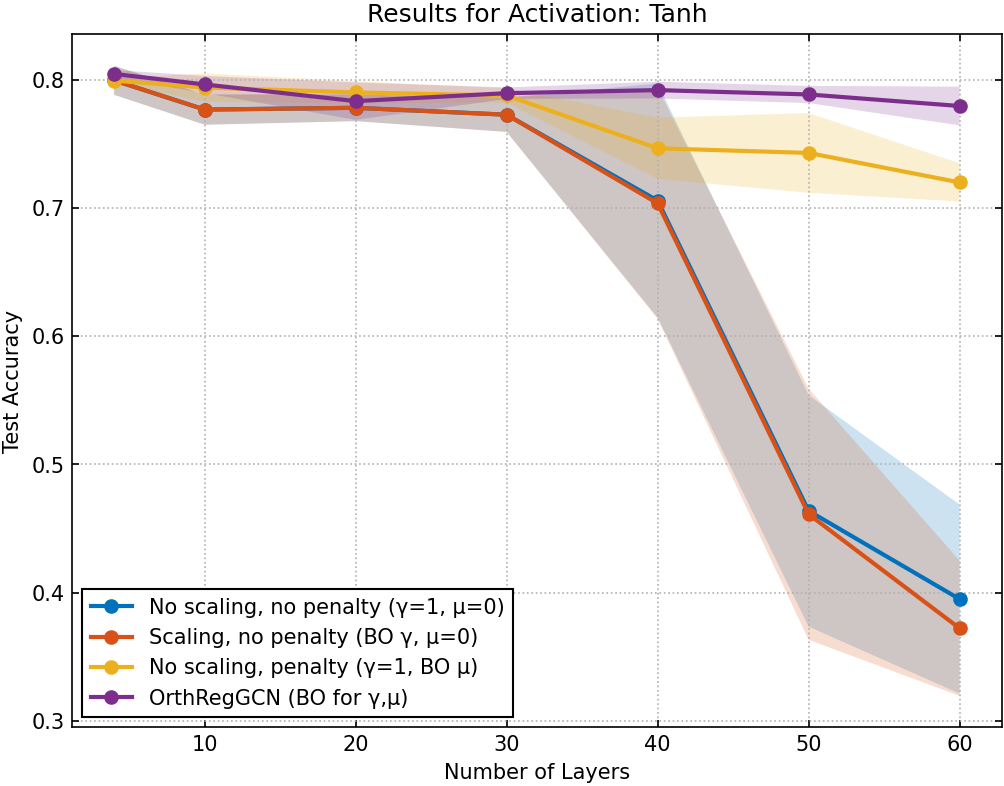

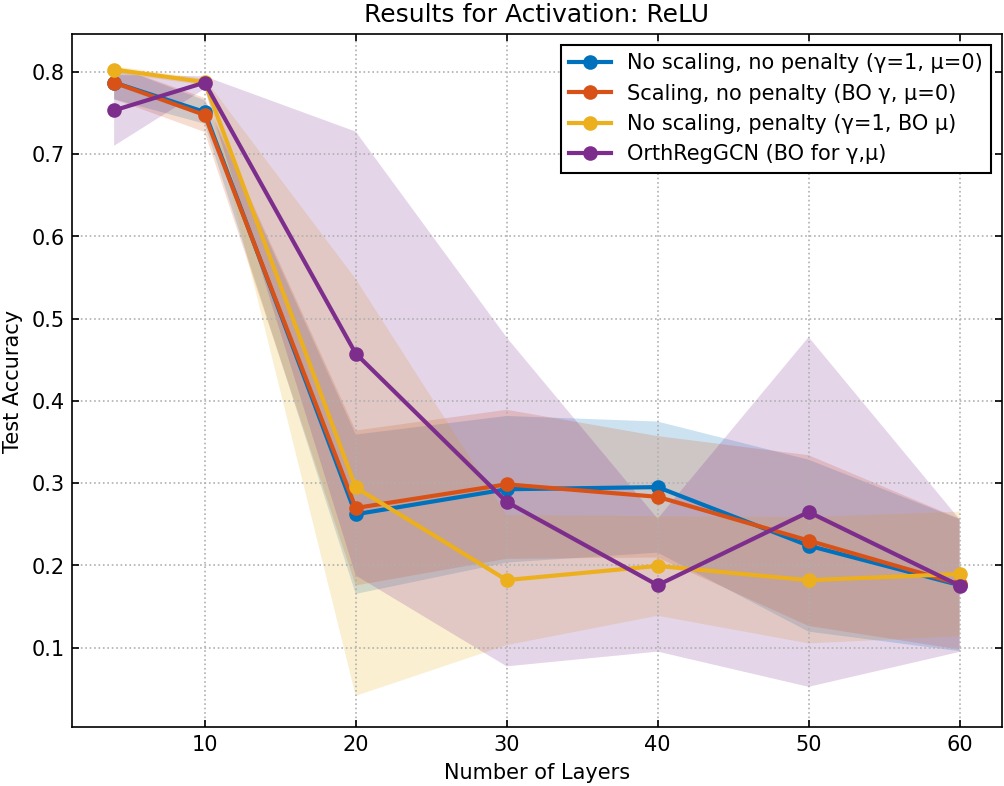

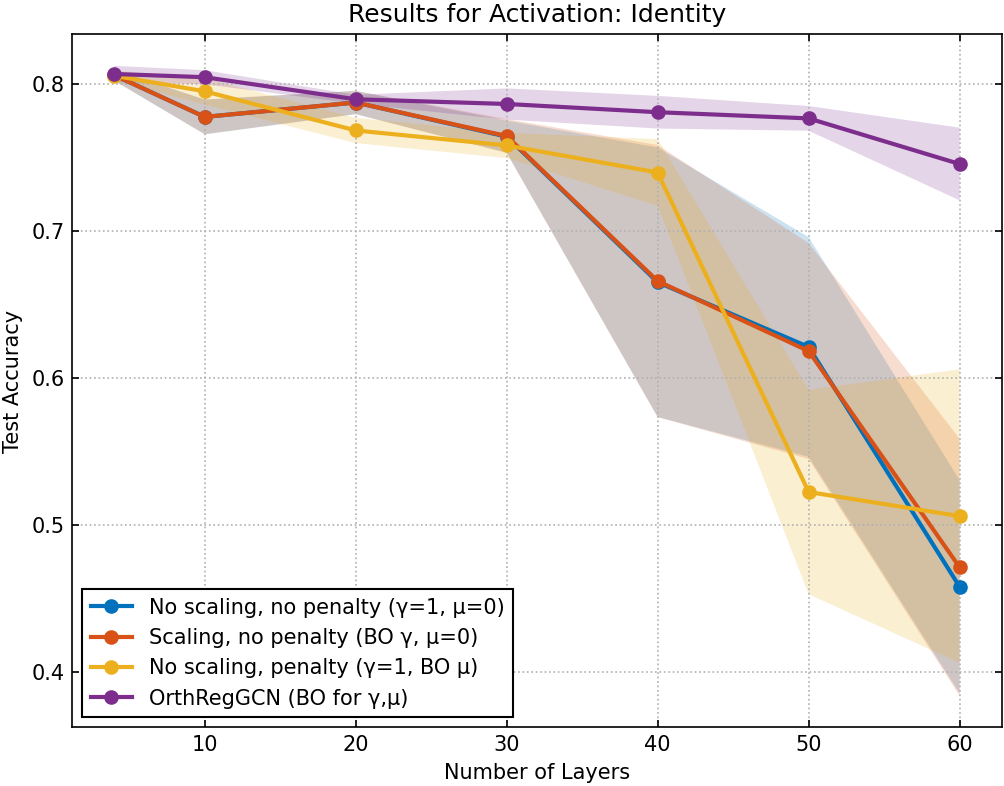

In [62]:
# -------------------------
# Plot the results
plot_all_activations()

# JACOBIAN PLOTS

Using device: cuda
[Cora | baseline | Layers: 40] Epoch: 000, Loss: 1.9477, Train: 0.1714, Val: 0.2040, Test: 0.2060
[Cora | baseline | Layers: 40] Epoch: 010, Loss: 1.9456, Train: 0.1714, Val: 0.1180, Test: 0.1120
[Cora | baseline | Layers: 40] Epoch: 020, Loss: 1.7702, Train: 0.2714, Val: 0.3180, Test: 0.2860
[Cora | baseline | Layers: 40] Epoch: 030, Loss: 1.8817, Train: 0.2643, Val: 0.2420, Test: 0.2290
[Cora | baseline | Layers: 40] Epoch: 040, Loss: 1.6952, Train: 0.2786, Val: 0.3100, Test: 0.2880
[Cora | baseline | Layers: 40] Epoch: 050, Loss: 1.6531, Train: 0.2714, Val: 0.3080, Test: 0.2820
[Cora | baseline | Layers: 40] Epoch: 060, Loss: 1.5954, Train: 0.3143, Val: 0.3040, Test: 0.2900
[Cora | baseline | Layers: 40] Epoch: 070, Loss: 1.5850, Train: 0.3500, Val: 0.2820, Test: 0.2740
[Cora | baseline | Layers: 40] Epoch: 080, Loss: 1.5879, Train: 0.3571, Val: 0.2560, Test: 0.2670
[Cora | baseline | Layers: 40] Epoch: 090, Loss: 1.5720, Train: 0.3571, Val: 0.2620, Test: 0.2690
[

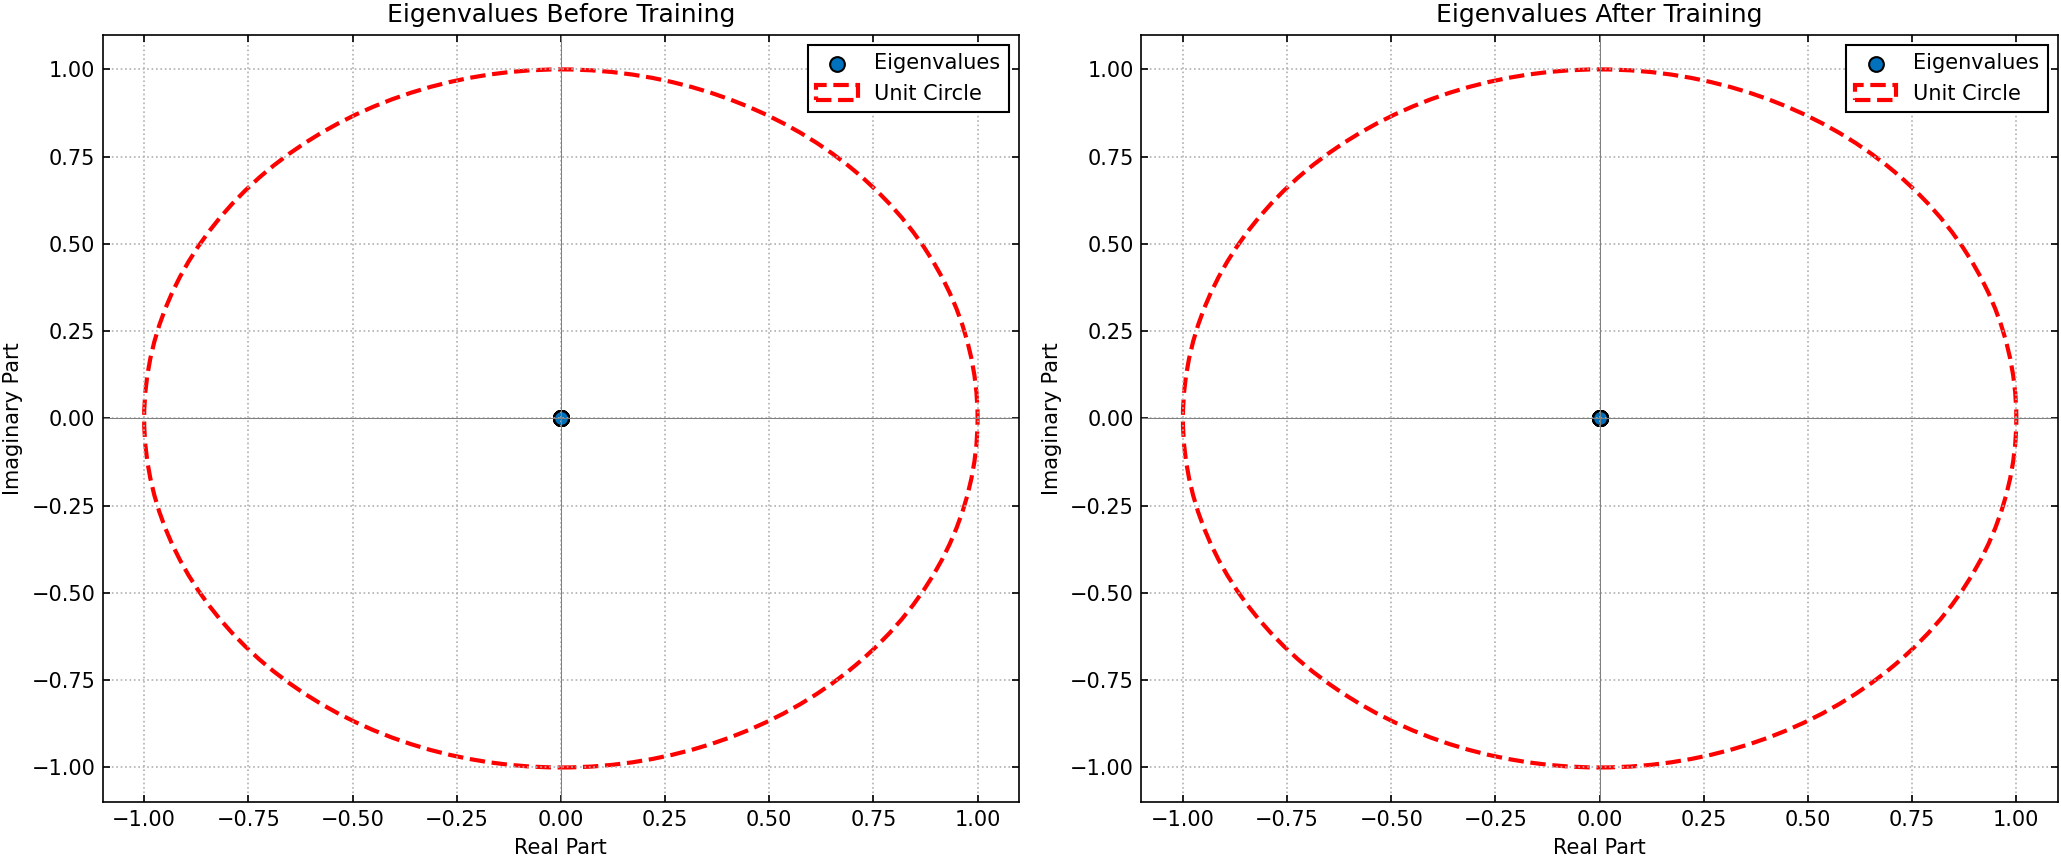

In [ ]:
# Load the Cora dataset.
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
dataset_name = 'Cora'
model_type = 'baseline'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set up the model.
in_channels = dataset.num_node_features
hidden_channels = training_params['hidden_channels']
out_channels = dataset.num_classes
num_layers = 40
activation = nn.Tanh()
model = GCN(in_channels,
                       hidden_channels,
                       out_channels,
                       num_layers,
                       activation)


model.to(device)
data.to(device)

def compute_jacobian_eigs(model, data, node_idx=0):
    """
    Computes the eigenvalues for the Jacobian of the hidden layer (latent) output for a given node.

    Parameters:
      model    : the GCN model.
      data     : graph data from the dataset.
      node_idx : the index of the node to analyze.

    Returns:
      eigenvalues: a NumPy array of eigenvalues.
    """
    model.eval()  # Ensure the model is in eval mode.
    # Use input features that require gradients.
    input_x = data.x.clone().detach().requires_grad_(True)

    def latent_for_node(x):
        # The forward pass returns logits and the hidden (latent) representation.
        _, latent = model(x, data.edge_index, return_latent=True)
        # Return the latent representation of the selected node.
        return latent[node_idx]

    # Compute the Jacobian of the latent representation (for one node) with respect to the input.
    # The raw Jacobian has shape [hidden_channels, num_nodes, in_channels]
    jac = torch.autograd.functional.jacobian(latent_for_node, input_x)
    # Extract the slice corresponding to the node (shape becomes [hidden_channels, in_channels]).
    jac_node = jac[:, node_idx, :]

    # To perform eigenvalue decomposition, form a square matrix.
    if jac_node.shape[0] != jac_node.shape[1]:
        J_square = jac_node @ jac_node.T  # This yields a [hidden_channels x hidden_channels] square matrix.
    else:
        J_square = jac_node
    # Eigenvalue decomposition (results may be complex).
    eigenvalues, _ = torch.linalg.eig(J_square)
    return eigenvalues.detach().cpu().numpy()

# Compute eigenvalues before training.
eig_before = compute_jacobian_eigs(model, data, node_idx=0)

# Train the model.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5)

best_val_acc = 0
best_epoch = 0
test_acc_at_best_val = 0

for epoch in range(training_params['max_epochs']):
    loss = train(model, 'baseline', data, optimizer, device)
    train_acc, val_acc, test_acc = test(model, data, device)
    scheduler.step(val_acc)
    if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            test_acc_at_best_val = test_acc

    if epoch % 10 == 0:
      print(f"[{dataset_name} | {model_type} | Layers: {num_layers}] Epoch: {epoch:03d}, Loss: {loss:.4f}, "
          f"Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")

    model.eval()
    with torch.no_grad():
        _, latent = model(data.x.to(device), data.edge_index.to(device), return_latent=True)


# Compute eigenvalues after training.
eig_after = compute_jacobian_eigs(model, data, node_idx=0)

# Create a plotting helper to add eigenvalues and the unit circle.
def plot_eigenvalues(ax, eigenvalues, title):
    ax.scatter(eigenvalues.real, eigenvalues.imag, s=50, edgecolor='k', label='Eigenvalues')
    # Plot the unit circle.
    circle = plt.Circle((0, 0), 1, color='r', fill=False, linestyle='--', linewidth=2, label='Unit Circle')
    ax.add_patch(circle)
    ax.set_xlabel("Real Part")
    ax.set_ylabel("Imaginary Part")
    ax.set_title(title)
    ax.axhline(0, color='grey', lw=0.5)
    ax.axvline(0, color='grey', lw=0.5)
    ax.grid(True)
    ax.legend()

# Plot eigenvalues before and after training in side-by-side subplots.
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plot_eigenvalues(axs[0], eig_before, "Eigenvalues Before Training")
plot_eigenvalues(axs[1], eig_after, "Eigenvalues After Training")
plt.tight_layout()
plt.show()